# Multivariate Time Series Forecasting of Sales Quantities with LightGBM

# 1. Introduction

### 1.1 Problem Statement
The goal of this project is to forecast the **daily quantity of products sold** in different cities for the next **10 days** using a multivariate time series approach.  
We aim to model and predict sales for each **product-city** combination using relevant numerical and categorical features from historical sales data.

We employ **LightGBM**, a fast, efficient gradient boosting framework that supports missing data and handles categorical features natively.

### 1.2 Objectives
- Explore and clean the dataset, including handling missing values and inconsistent time gaps.
- Perform **feature engineering**, including the extraction of temporal features (e.g., day of week, month, holiday flags), and apply autocorrelation/partial autocorrelation analysis.
- Train a LightGBM model to forecast product sales per city for a 10-day horizon.
- Evaluate model performance using **SMAPE** (Symmetric Mean Absolute Percentage Error).
- Visualize the forecasts compared to actual sales values.

### 1.3 Dataset Description
The dataset includes the following features:

- **quantity**: Target variable; the quantity of the product sold on a given day.
- **unit_price**: The unit sale price of the product.
- **retail_price**: The listed (non-discounted) price of the product.
- **discount**: The discount applied to the product.
- **date**: Date of the transaction.
- **product_name**: Categorical; one of three products: 'x', 'y', or 'z'.
- **city**: Categorical; one of 'Cairo', 'North', or 'Giza'.
- **area**: Categorical; 64 unique area identifiers within the cities.

> Note: The dataset contains **irregular time gaps**, which will be addressed during preprocessing.

# 2. Data Cleaning and Exploration

In [3]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### 2.1. Loading the Dataset

In [2]:
df_original = pd.read_csv("data/product_sales_dataset.csv")
num_of_example = df_original.shape[0]
df_original.head()

quantity  UnitePrice  discount                  date  retail price  \
0        33        16.0      20.0  2021-10-29T03:33:52Z          16.0   
1        30        16.0      20.0  2021-10-23T12:29:27Z          16.0   
2         2        45.0      30.0  2021-08-03T09:14:16Z          45.0   
3         3        16.0       3.0  2021-08-17T09:00:50Z          16.0   
4         1        45.0      27.0  2021-09-06T19:57:02Z          45.0   

  product_name          area   city  
0    product y        Bahary  North  
1    product y  Dar El-Salam  Cairo  
2    product z         Miamy  North  
3    product y         Miamy  North  
4    product z         Miamy  North

In [3]:
# Get the list of column names
columns = list(df_original.columns)
print("Dataset columns: ", list(columns))

# Extract the last three columns (categorical columns)
cat_column = columns[-3:]

# Print unique values for each categorical column
for col in cat_column:
    print(f"The unique value for '{col}' column: {list(df_original[col].unique())}")

Dataset columns:  ['quantity', 'UnitePrice', 'discount', 'date', 'retail price', 'product_name', 'area', 'city']
The unique value for 'product_name' column: ['product y', 'product z', 'product x ']
The unique value for 'area' column: ['Bahary', 'Dar El-Salam', 'Miamy', 'Hadayek El-Kobba', 'Ain Shams', 'Nasr City', 'Faisal', 'El-Haram', 'El-Mokattam', 'El-Zaitoun', 'El-Mandara', '6th of October', 'Heliopolis', 'Damanhur', 'El-Seyouf', 'Burj Al-Arab', 'Smouha', 'Sidy Gaber', 'El-Minia City', 'Imbaba', 'Bakos', 'Hadayek El-Ahram', 'Dayrout', 'Sidy Bishr', 'Moharam Bek', 'El-Agamy', 'Beni Suef City', 'El-Asafra', 'El-Marg', 'El-Sheikh Zayed', 'Dokki and Mohandessin', 'Shibin El-Kom', 'El-Maadi', 'New Cairo', 'El-Montazah', 'El-Matareya', 'El-Mansoura', 'Victoria', 'Roshdy', nan, 'Loran', 'Saba Basha', 'El-Werdeyan', 'Glym', 'Mahatet El-Raml', 'Janaklees', 'Fleming', 'Zizenia', 'Abou Keir', 'West El-Balad', 'Stanley', 'Bulkly', 'El-Mansheyah', 'El-Amreya', 'El-Ibrahimia', 'Ø¹Ø¬Ù„ÙˆÙ†', 'San

Editing the column names and remove any trailing spaces, such as in the **'product x '** column,  
to ensure consistent naming throughout the dataset.

In [127]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2995 entries, 0 to 2994
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   quantity      2995 non-null   int64  
 1   UnitePrice    2995 non-null   float64
 2   discount      2995 non-null   float64
 3   date          2995 non-null   object 
 4   retail price  2995 non-null   float64
 5   product_name  2995 non-null   object 
 6   area          2970 non-null   object 
 7   city          2995 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 187.3+ KB


### 2.2 Column Renaming and Product Name Cleaning

We start by renaming the dataset columns for clarity and consistency.  
Next, we clean the `product_name` column by:

- Removing any leading or trailing whitespaces,
- Replacing verbose product names (e.g., `'product_name x'`) with simpler identifiers (`'x'`, `'y'`, `'z'`).

In [128]:
df_original.columns = ['quantity', 'unit_price', 'discount', 'time_step', 
                       'retail_price', 'product_name', 'area', 'city']

df_original['product_name'] = df_original['product_name'].str.strip()  # Remove leading/trailing spaces
df_original['product_name'] = df_original['product_name'].replace({
    'product_name x': 'x', 
    'product_name y': 'y', 
    'product_name z': 'z'  
})

### 2.3 Handling `area` Columns

The `area` column contains both nulls and corrupted entries (e.g., `Ø¹Ø¬Ù„ÙˆÙ†`).  
We use regex filtering to keep only valid alphanumeric names (with optional spaces or hyphens).  
Invalid values are replaced with `NaN` for imputation.


In [129]:
import re
import pandas as pd
import numpy as np

def english_check(df, column):
    """
    This function checks whether the values in the specified column match a valid pattern
    (alphanumeric characters, spaces, or hyphens) and replaces invalid values with NaN.
    """
    def is_valid_area(value):
        """
        This helper function checks if a given value is valid according to the pattern.
        """
        if pd.isna(value):  # Check if the value is NaN
            return True  # Consider NaN as valid (it will be handled later)
        # Check if the value matches the pattern (alphanumeric, spaces, or hyphens)
        return bool(re.match(r'^[a-zA-Z0-9]+(?:[\s-][a-zA-Z0-9]+)*$', value))
    
    df = df.copy()
    # Apply the 'is_valid_area' function to each value in the specified column
    # Invalid values (those that do not match the pattern) are replaced with NaN
    df[column] = df[column].apply(lambda x: x if is_valid_area(x) else np.nan)

    return df

df_original = english_check(df_original, 'area')

***KNN Imputation for Missing `area` Values***

We impute missing values in the `area` column using KNN, applied separately within each city.  
The imputation uses numerical features along with encoded city and product identifiers.  
Imputed `area` labels are decoded back to original string values.

In [130]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

def handel_missing_area_KNN(df, num_cols, product_col, city_col, area_col, time_column=None):
    """
    Handles missing values in the 'area' column by applying KNN imputation within each city.
    """
    df = df.copy()

    # Handle time column if provided (create 'days_since_start' feature)
    if time_column:
        df[time_column] = pd.to_datetime(df[time_column])
        df['days_since_start'] = (df[time_column] - df[time_column].min()).dt.days
        num_cols += ['days_since_start']  # Add the new time-related feature to num_cols
    
    # Encode categorical columns 'city' and 'product' using LabelEncoder
    city_encoder = LabelEncoder()
    df['city_encoder'] = city_encoder.fit_transform(df[city_col])
    
    product_encoder = LabelEncoder()
    df['product_encoder'] = product_encoder.fit_transform(df[product_col])

    # Temporarily fill missing 'area' values with a placeholder ('missing') for encoding
    area_encoder = LabelEncoder()
    df['area_encoded'] = df[area_col].fillna('missing')  # Fill missing values temporarily
    
    # Iterate through each unique city and apply KNN imputation separately for each city
    cities = df[city_col].unique()  # Get unique cities in the dataset

    # Initialize KNN imputer
    knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

    # Create a new column to store the imputed 'area' values
    df['area_imputed'] = df[area_col]  # Start with the original 'area' values

    # Perform KNN imputation within each city
    for city in cities:
        # Filter data for the current city
        city_data = df[df[city_col] == city].copy()

        # Fit LabelEncoder for 'area' within the current city (to ensure city-specific encoding)
        area_values = city_data['area_encoded'].unique()
        area_encoder.fit(area_values)  # Fit the encoder to the unique area values in this city

        # Encode the 'area' values within the city
        city_data['area_encoded'] = area_encoder.transform(city_data['area_encoded'])
        
        # Set missing 'area' values to NaN for imputation
        city_data.loc[city_data[area_col].isna(), 'area_encoded'] = np.nan

        # Select features for KNN imputation
        features = num_cols + ['product_encoder', 'city_encoder', 'area_encoded']
        X = city_data[features]

        # Apply KNN imputation to fill missing 'area' values
        imputed_values = knn_imputer.fit_transform(X)

        # Extract the imputed area values (round to nearest valid index)
        imputed_area_values = imputed_values[:, -1].round().astype(int)

        # Map imputed area values back to original labels
        city_data['area_imputed'] = area_encoder.inverse_transform(imputed_area_values)

        # Update the original DataFrame with the imputed 'area' values
        df.loc[df[city_col] == city, 'area_imputed'] = city_data['area_imputed']

    # Drop unnecessary columns 
    df.drop(columns=['city_encoder', 'product_encoder', 'area_encoded'], inplace=True)

    if time_column:
        df.drop(columns=['days_since_start'], inplace=True)

    return df

df_original = handel_missing_area_KNN(df_original, num_cols=['quantity', 'unit_price', 'discount'],
                             product_col='product_name', city_col='city', 
                             area_col='area', time_column='time_step')
df_original['area'] = df_original['area_imputed']
df_original.drop(columns=['area_imputed'], inplace=True)
# df_original[df_original['area'].isna()][['city','area']]

In [131]:
df_original['area'].unique()

array(['Bahary', 'Dar El-Salam', 'Miamy', 'Hadayek El-Kobba', 'Ain Shams',
       'Nasr City', 'Faisal', 'El-Haram', 'El-Mokattam', 'El-Zaitoun',
       'El-Mandara', '6th of October', 'Heliopolis', 'Damanhur',
       'El-Seyouf', 'Burj Al-Arab', 'Smouha', 'Sidy Gaber',
       'El-Minia City', 'Imbaba', 'Bakos', 'Hadayek El-Ahram', 'Dayrout',
       'Sidy Bishr', 'Moharam Bek', 'El-Agamy', 'Beni Suef City',
       'El-Asafra', 'El-Marg', 'El-Sheikh Zayed', 'Dokki and Mohandessin',
       'Shibin El-Kom', 'El-Maadi', 'New Cairo', 'El-Montazah',
       'El-Matareya', 'El-Mansoura', 'Victoria', 'Roshdy', 'El-Ayyat',
       'Loran', 'Saba Basha', 'El-Mansheyah', 'El-Werdeyan', 'Glym',
       'Mahatet El-Raml', 'Janaklees', 'Fleming', 'Zizenia', 'Helwan',
       'Madinaty', 'Shoubra', 'Abou Keir', 'West El-Balad', 'Stanley',
       'Bulkly', 'El-Amreya', 'El-Ibrahimia', 'Kafr El-Dawar City',
       'San Stefano', 'Al Sulaimaniyah', 'El-Obour City', 'El-Mahmoudeya',
       'Marsa Matrouh', '

### 2.4 Handling Outliers using **Capping (Winsorization)**

- We cap values above the **95th percentile** for `quantity` to limit the impact of extreme outliers.
- We cap values above the **98th percentile** for `discount`.
- Any negative `discount` values are set to zero for valid pricing.
- Any `discount` values greater than 100 are set to 100 to maintain reasonable pricing.

In [132]:
# Calculate the 95th percentile for 'quantity' and cap values above it
percentile_q = df_original['quantity'].quantile(0.95)
df_original['quantity'] = np.where(df_original['quantity'] > percentile_q, int(percentile_q), df_original['quantity'])

# Calculate the 98th percentile for 'discount' and cap values above it
percentile_d = df_original['discount'].quantile(0.98)
df_original['discount'] = np.where(df_original['discount'] > percentile_d, percentile_d, df_original['discount'])

# Set any negative discount values to zero
df_original.loc[df_original['discount'] < 0, 'discount'] = 0

# Set any discount greater than 100 to 100
df_original.loc[df_original['discount'] > 100, 'discount'] = 100

### 2.5 Checking Correlations to Handle Multicollinearity

We examine the correlation between numerical features to detect multicollinearity.

- The correlation matrix shows that `unit_price` and `retail_price` are highly correlated (≈ 0.93).
- To reduce redundancy and improve model stability, we drop the `retail_price` column.

In [133]:
# List of numerical columns to check correlations
num_columns = ['quantity', 'discount', 'unit_price', 'retail_price']

# Calculate the correlation matrix
corr_matrix = df_original[num_columns].corr()

# Loop through each column and print its correlation with other columns
for column in num_columns:
    print(f"The correlation between the '{column}' column and other columns:")
    print(corr_matrix[column].sort_values(ascending=False))
    print("\n")

The correlation between the 'quantity' column and other columns:
quantity        1.000000
discount       -0.173490
retail_price   -0.217759
unit_price     -0.249462
Name: quantity, dtype: float64


The correlation between the 'discount' column and other columns:
discount        1.000000
unit_price      0.803833
retail_price    0.752251
quantity       -0.173490
Name: discount, dtype: float64


The correlation between the 'unit_price' column and other columns:
unit_price      1.000000
retail_price    0.930889
discount        0.803833
quantity       -0.249462
Name: unit_price, dtype: float64


The correlation between the 'retail_price' column and other columns:
retail_price    1.000000
unit_price      0.930889
discount        0.752251
quantity       -0.217759
Name: retail_price, dtype: float64




In [134]:
df_original = df_original.drop('retail_price', axis=1)

In [135]:
df_original.head(2)

quantity  unit_price  discount                 time_step product_name  \
0        15        16.0      20.0 2021-10-29 03:33:52+00:00    product y   
1        15        16.0      20.0 2021-10-23 12:29:27+00:00    product y   

           area   city  
0        Bahary  North  
1  Dar El-Salam  Cairo

#### 2.6 Ensuring Time Continuity and Removing Early Gaps

- Converted the `time_step` column to datetime format and sorted the dataset in chronological order.  
- Identified the largest gaps in daily continuity and removed early records to ensure a regular time sequence.  
- This step improves the reliability of the time series model by maintaining a consistent temporal structure.  
- After filtering, we effectively removed the first year, which contained approximately **85% missing days** and introduced significant irregularities.

In [136]:
# Convert 'time_step' datetime
df_original['time_step'] = pd.to_datetime(df_original['time_step']) 

# Sort the DataFrame by the 'time_step' column to ensure chronological order
df_original = df_original.sort_values('time_step').reset_index(drop=True)

# Extract only the date part from 'time_step', ignoring the time component
df_original['time_step'] = df_original['time_step'].dt.date

In [137]:
# Calculate the time difference in days between consecutive rows
df_original['time_diff'] = df_original['time_step'].shift(1) - df_original['time_step']

# Convert the time difference into timedelta and extract absolute values
df_original['time_diff'] = abs(pd.to_timedelta(df_original['time_diff']))

# Find the 10 largest time gaps
top_10_gaps = df_original['time_diff'].nlargest(10)

# Sort the rows with the largest gaps by 'time_step' to prioritize gap reduction
result = df_original.iloc[top_10_gaps.index].sort_values('time_step')

result

quantity  unit_price  discount   time_step product_name              area  \
1          1        16.0       9.0  2021-04-30    product y         Ain Shams   
2         10        16.0       9.0  2021-05-08    product y        El-Zaitoun   
4         10        16.0      20.0  2021-05-22    product y             Bakos   
8         10        16.0      20.0  2021-06-06    product y        Sidy Gaber   
16         2       102.0      33.0  2021-08-02    product x       El-Mokattam   
18        15        16.0      20.0  2021-08-12    product y     Shibin El-Kom   
21         2       102.0      35.0  2021-08-26    product x       Moharam Bek   
22         1        45.0      27.0  2021-09-06    product z             Miamy   
28         1        16.0       3.0  2021-09-30    product y             Miamy   
97         3        45.0      30.0  2022-01-20    product z  Hadayek El-Ahram   

     city time_diff  
1   Cairo   30 days  
2   Cairo    8 days  
4   North   14 days  
8   North   10 days  
16  Cairo   47 days  
18   Giza    9 days  
21  North    7 days  
22  North   11 days  
28  North   20 days  
97   Giza   14 days

In [138]:
# Filter the original DataFrame to include rows starting from the largest gap
start_time = result.iloc[-1]['time_step']

df_original.drop('time_diff', axis=1, inplace=True)  

# Filter rows based on the largest gap's start time and then reset the index
df_original = df_original[df_original['time_step'] >= start_time]      
df_original = df_original.reset_index(drop=True)              

# df_original.head()                             

In [139]:
print(f"The number of deleted examples: {num_of_example - df_original.shape[0]} example.")
print(f"The number of examples: {df_original.shape[0]} example.")

The number of deleted examples: 97 example.
The number of examples: 2898 example.


In [140]:
df_time = df_original.copy()
df_time['time_step'] = pd.to_datetime(df_time['time_step'], format='time_step')
df_time.set_index('time_step', drop=True, inplace=True)
df_time.head()

quantity  unit_price  discount product_name              area  \
time_step                                                                   
2022-01-20         3       45.00      30.0    product z  Hadayek El-Ahram   
2022-01-24         3       45.00      26.0    product z       El-Montazah   
2022-01-26         5       89.75      30.0    product x     El-Minia City   
2022-01-27         4       89.75      29.0    product x       Moharam Bek   
2022-01-29         3       89.75      27.0    product x            Roshdy   

             city  
time_step          
2022-01-20   Giza  
2022-01-24  North  
2022-01-26   Giza  
2022-01-27  North  
2022-01-29  North

In [141]:
df = df_original.copy()
df['time_step'] = pd.to_datetime(df['time_step'])

# 3. Data Analysis

In this section, we will explore key characteristics of the dataset, visualize trends, and identify patterns across time, products, and cities.  
The goal is to extract insights that inform feature engineering and model development.

### 3.1 Seasonality Check

We use seasonal decomposition to detect repeating patterns in sales.

- Applied to daily quantity data for each city-product pair.
- Visualized the seasonal component over the last 100 days.
- Identified top seasonal peaks to estimate periodicity.

✅ **Result**: Found a clear **7-day seasonality**, showing strong weekly patterns in sales.

This helps us design better lag features like `quantity(t−7)` for time-based models.

In [142]:
from statsmodels.tsa.seasonal import seasonal_decompose
def check_seasonality(df, city, product):
    data_frame = df.query("city == @city & product_name == @product")
    data_frame = data_frame.resample('D')['quantity'].sum()
    data_frame[data_frame==0] = np.nan
    data_frame = data_frame.interpolate(method='time')
    
    # Perform seasonal decomposition of the time series
    res = seasonal_decompose(data_frame, model='additive')
    # Extract the seasonal component
    season = res.seasonal

    plt.figure(figsize=(10, 6)) 
    plt.plot(data_frame.index[-100:], season[-100:], color='b', marker="o", label="Seasonal Component")
    plt.title(f"Seasonal Component for {city}-{product}", fontsize=14)  # Add title with font size
    plt.ylabel("Value", fontsize=12) 
    plt.xlabel("Date", fontsize=12)  
    plt.grid(True)  
    plt.xticks(rotation=90)  
    plt.tight_layout()  
    plt.legend(loc='upper right') 
    plt.show()

    # Identify the top 10 largest seasonal values and calculate the periodicity
    large_10 = season.nlargest(10)
    # Calculate the seasonal period (time difference between the first two peaks)
    seasonal_period = (large_10.index[1] - large_10.index[0]).days
    print(f"Period of seasonality: {seasonal_period} days")
    # Identify the day of the week with the highest sales
    highest_sales_day = large_10.index[0].day_name()
    print(f"Highest sales occur on {highest_sales_day} weekly.")
    return seasonal_period

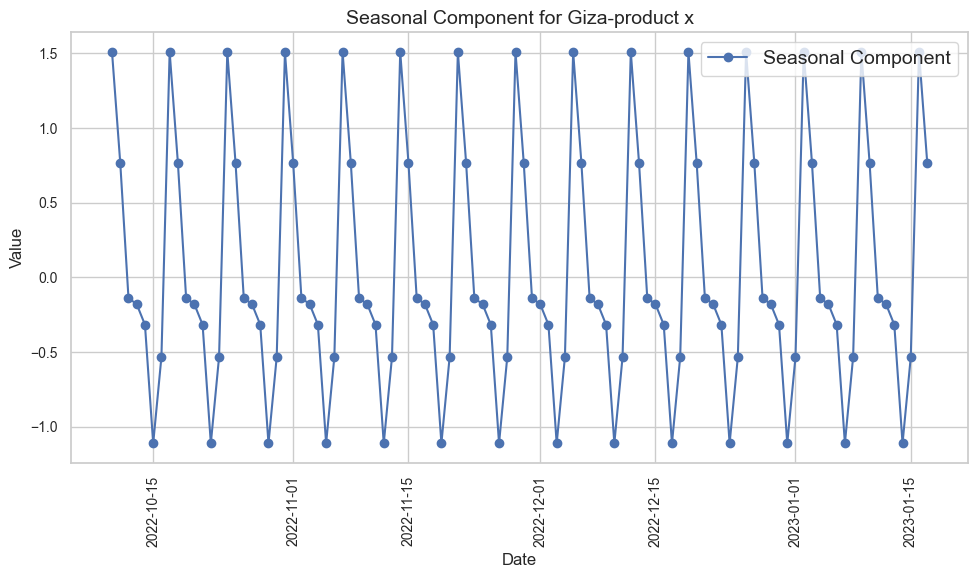

Period of seasonality: 7 days
Highest sales occur on Monday weekly.


In [143]:
seasonal_period = check_seasonality(df_time, 'Giza','product x')

### 3.2 Correlation (ACF, PACF, CCF)

We analyze time dependencies using:

- **ACF (Autocorrelation Function)** to see how current values relate to past values.
- **PACF (Partial ACF)** to identify direct lags that affect the current value.
- **CCF (Cross-Correlation Function)** to assess lag relationships between `quantity` and features like `discount` and `unit_price`.

This helps determine how many delayed (lagged) features to include for forecasting models.

In [144]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf

def plot_correlation(df, city, product):
    # Filter and preprocess the data for the selected city and product
    data_frame = df.query("city == @city & product_name == @product")
    data_frame = data_frame.resample('D')[['quantity', 'discount','unit_price']].sum()
    data_frame[data_frame == 0] = np.nan
    data_frame = data_frame.interpolate(method='time')
    
    # Create a 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Plot ACF
    plot_acf(data_frame['quantity'], ax=axes[0, 0])
    axes[0, 0].set_title(f"ACF for {city}-{product}", fontsize=14)
    axes[0, 0].set_ylabel("ACF Value", fontsize=12)
    axes[0, 0].set_xlabel("Lags", fontsize=12)
    axes[0, 0].grid(True)
    
    # Plot PACF
    plot_pacf(data_frame['quantity'], ax=axes[0, 1], method='ywm')
    axes[0, 1].set_title(f"PACF for {city}-{product}", fontsize=14)
    axes[0, 1].set_ylabel("PACF Value", fontsize=12)
    axes[0, 1].set_xlabel("Lags", fontsize=12)
    axes[0, 1].grid(True)
    
    # Plot CCF between 'quantity' and 'discount'
    plot_ccf(data_frame['quantity'], data_frame['discount'], ax=axes[1, 0])
    axes[1, 0].set_title(f"CCF (Quantity vs Discount) for {city}-{product}", fontsize=14)
    axes[1, 0].set_ylabel("CCF Value", fontsize=12)
    axes[1, 0].set_xlabel("Lags", fontsize=12)
    axes[1, 0].grid(True)
    
    # Plot CCF between 'quantity' and 'unit-price'
    plot_ccf(data_frame['quantity'], data_frame['unit_price'], ax=axes[1, 1])
    axes[1, 1].set_title(f"CCF (Quantity vs Unit Price) for {city}-{product}", fontsize=14)
    axes[1, 1].set_ylabel("CCF Value", fontsize=12)
    axes[1, 1].set_xlabel("Lags", fontsize=12)
    axes[1, 1].grid(True)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

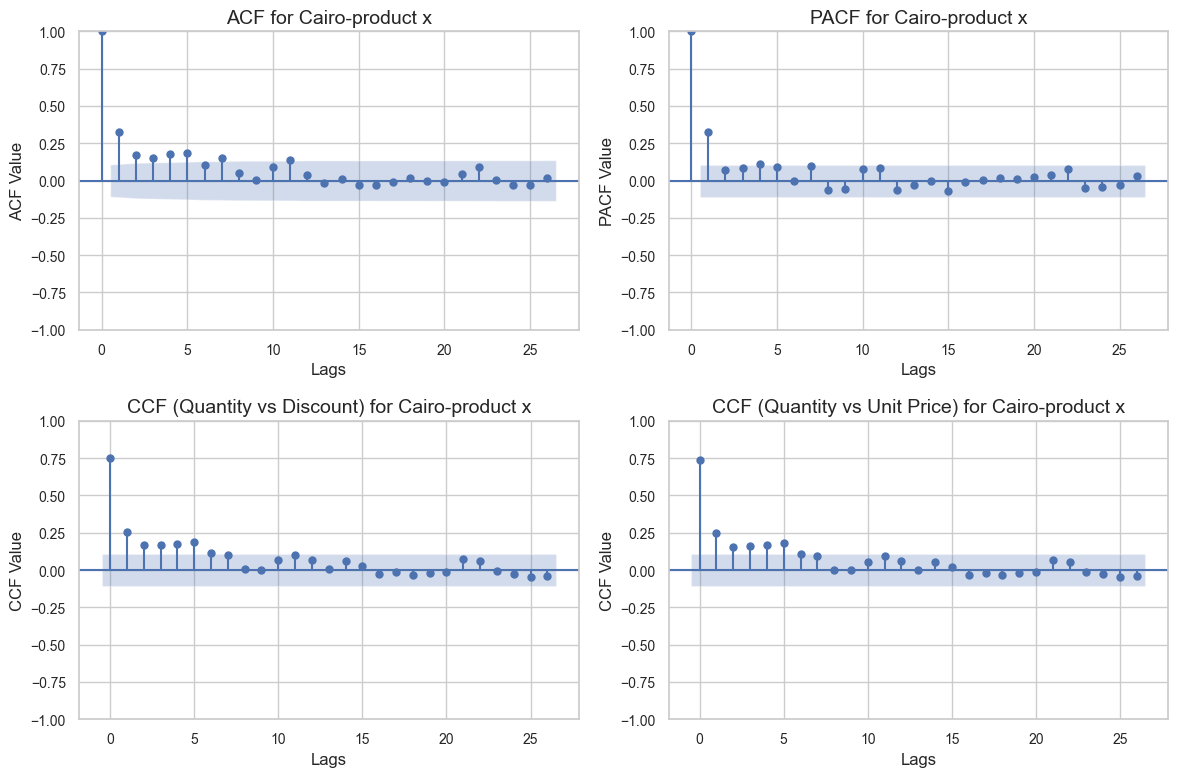

In [145]:
plot_correlation(df_time, 'Cairo','product x')

### 3.3 Check Sales  

#### 1. Sales by Area within Each City

We analyze the total quantity sold per area for each city.  
  
This helps identify high-performing areas within cities and supports targeted decision-making.


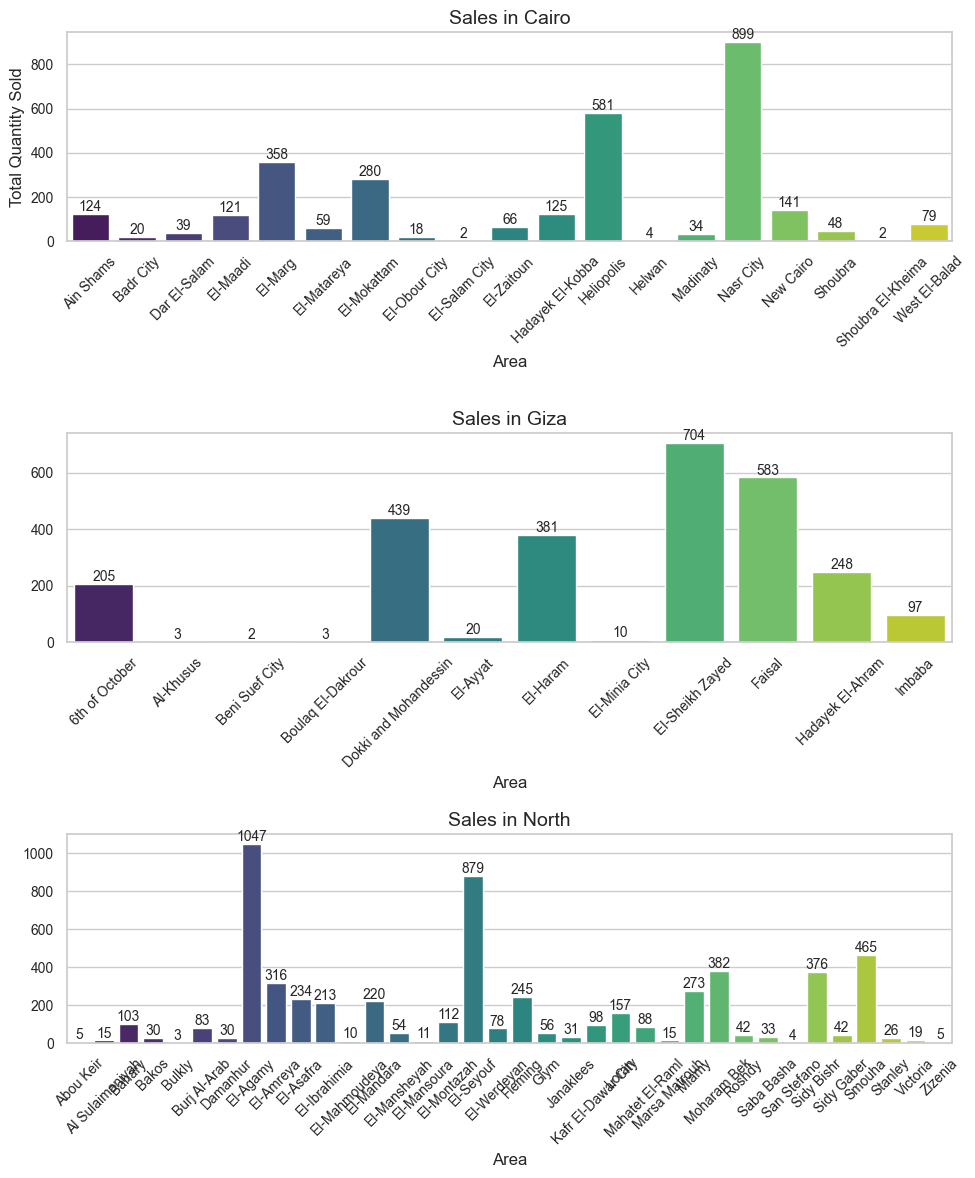

In [146]:
df = df_original.copy()

city_area_sales = df.groupby(['city', 'area'])['quantity'].sum().reset_index()

cities = city_area_sales['city'].unique()

fig, axes = plt.subplots(len(cities), 1, figsize=(10, 4 * len(cities)))

for idx, (city, ax) in enumerate(zip(cities, axes)):
    city_data = city_area_sales[city_area_sales['city'] == city]
    
    sns.barplot(
        data=city_data,
        x='area',
        y='quantity',
        ax=ax,
        palette='viridis',
        errorbar=None
    )
    
    ax.set_title(f"Sales in {city}", fontsize=14)
    ax.set_xlabel("Area", fontsize=12)
    ax.set_ylabel("Total Quantity Sold" if idx == 0 else "", fontsize=12)  # Only show y-label for first plot
    ax.tick_params(axis='x', rotation=45)
    
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.0f}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=10
        )

plt.tight_layout()
plt.show()

#### 2. Sales by Product within Area and City

We further analyze sales by product within each area and city.  
  
This analysis provides a deeper understanding of product performance within different geographic areas.


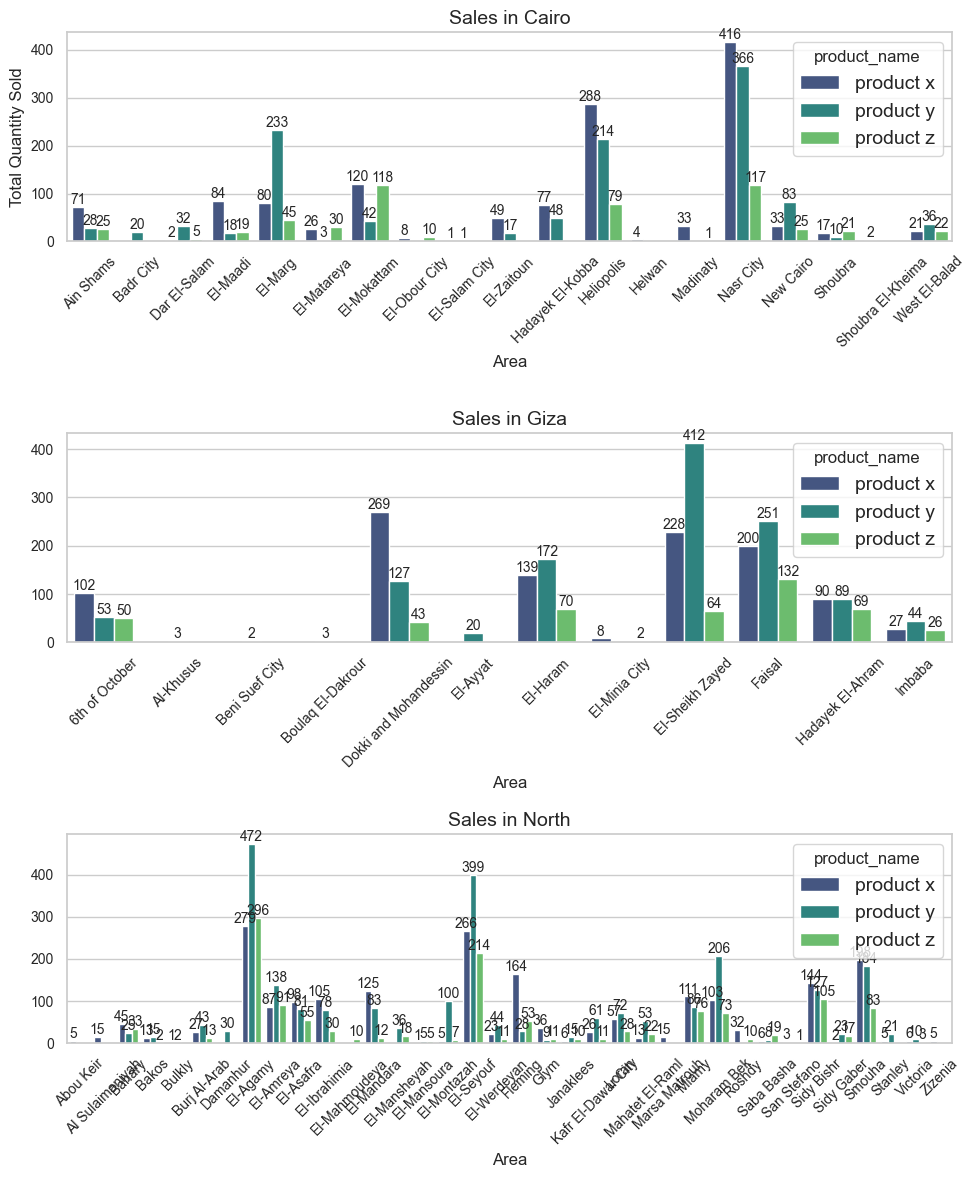

In [147]:
city_area_product_sales = df.groupby(['city', 'area', 'product_name'])['quantity'].sum().reset_index()

fig, axes = plt.subplots(len(cities), 1, figsize=(10, 4 * len(cities)))

for idx, (city, ax) in enumerate(zip(cities, axes)):
    city_data = city_area_product_sales[city_area_product_sales['city'] == city]
    
    sns.barplot(
        data=city_data,
        x='area',
        y='quantity',
        hue='product_name',
        ax=ax,
        palette='viridis',
        errorbar=None
    )
    
    ax.set_title(f"Sales in {city}", fontsize=14)
    ax.set_xlabel("Area", fontsize=12)
    ax.set_ylabel("Total Quantity Sold" if idx == 0 else "", fontsize=12)  # Only show y-label for the first plot
    ax.tick_params(axis='x', rotation=45)
    
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.0f}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=10
        )

plt.tight_layout()
plt.show()


#### 3. Sales by Product in Each City

In this analysis, we examine the total quantity of products sold in each city.  
  
This visualization provides valuable insights into city-level product sales distribution.

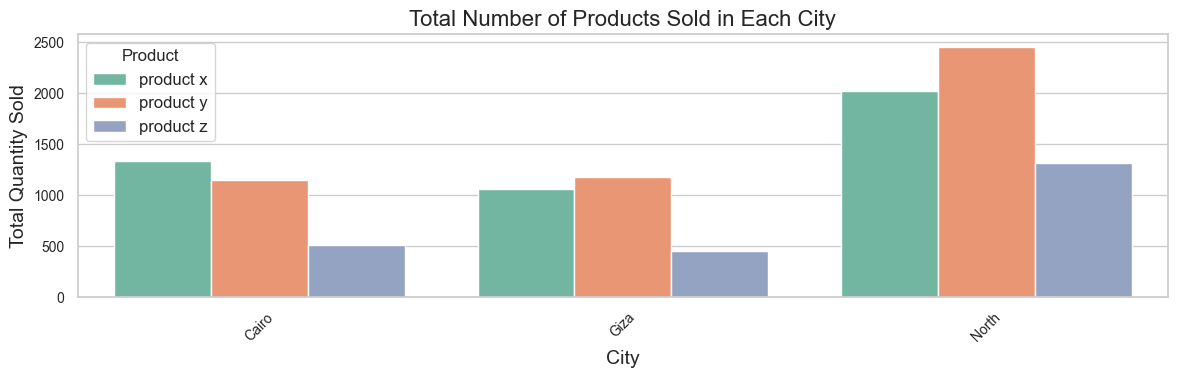

In [148]:
city_product_sales = df.groupby(['city', 'product_name'])['quantity'].sum().reset_index()

plt.figure(figsize=(12, 4))
sns.barplot(
    data=city_product_sales, 
    x='city', 
    y='quantity', 
    hue='product_name', 
    palette='Set2'
)
plt.title("Total Number of Products Sold in Each City", fontsize=16)
plt.xlabel("City", fontsize=14)
plt.ylabel("Total Quantity Sold", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Product", fontsize=12)
plt.tight_layout()
plt.show()


### Helper Function: Generate Complete Time Step-Product-Name-City Grid

This function creates a complete time series grid for all city-product combinations, ensuring that every possible combination of time_step, city, and product_name exists in the dataset. It handles missing combinations by filling them with NaN values. The grid is generated as a MultiIndex based on the full date range for all cities and products.

**Usage:**  
This helper function will be used for analyzing missing data during data completeness analysis and for future feature engineering tasks.

In [149]:
# Generate complete time_step-product_name-city grid
def create_complete_grid(df):
    # Get global time_step range
    df = df.copy()
    df['time_step'] = pd.to_datetime(df['time_step'])

    all_dates = pd.date_range(df['time_step'].min(), df['time_step'].max(), freq='D')

    # Get unique cities and products
    cities = df['city'].unique()
    products = df['product_name'].unique()

    # Create full MultiIndex
    complete_index = pd.MultiIndex.from_product(
        [all_dates, cities, products],
        names=['time_step', 'city', 'product_name']
    )

    # Process data
    df = (
        df
        .groupby(['time_step', 'city', 'product_name'])
        .agg({'quantity': 'sum', 'discount': 'mean', 'unit_price': 'mean'})
        .reindex(complete_index)  # Fill missing combinations
        .fillna({'quantity': 0, 'discount': 0.0, 'unit_price': 0.0})
        .astype({'quantity': int, 'discount': float, 'unit_price': float})
        .reset_index()
    )
    df.loc[df.quantity == 0, ['quantity', 'discount' , 'unit_price']] = np.nan
    return df

### 3.4 Data Completeness Analysis

In this step, we analyze the data completeness for various city-product combinations by checking the consistency and availability of data for each combination.  
  
This analysis helps identify gaps in the data and highlights city-product combinations with significant missing data, which may require further cleaning or imputation.


In [150]:
def analyze_data_completeness(df_grid, resample_freq='D'):
    """
    Analyze data completeness for all city-product combinations with consistent date ranges.
    """
    df_grid.time_step = pd.to_datetime(df_grid.time_step)
    global_start = df_grid.time_step.min()
    global_end = df_grid.time_step.max()
    full_date_range = pd.date_range(start=global_start, end=global_end, freq=resample_freq)
    total_days = len(full_date_range)
    
    cities = df_grid.city.unique()
    products = df_grid.product_name.unique()
    results = []
    for city in cities:
        for product in products:
            df_city_product = df_grid[(df_grid.city == city) & (df_grid.product_name == product)]
            missing_days = df_city_product.quantity.isna().sum()
            valid_days = total_days - missing_days
        
            first_data = df_city_product.dropna()['time_step'].min()
            last_data = df_city_product.dropna()['time_step'].max()
            
            results.append({
                'city': city,
                'product': product,
                'total_days': total_days,
                'valid_days': valid_days,
                'missing_days': missing_days,
                'valid_percent': round(valid_days / total_days * 100.0, 2),
                'missing_percent': round(missing_days / total_days * 100.0, 2),
                'global_start': global_start.date(),
                'global_end': global_end.date(),
                'first_data_date': first_data.date() if not pd.isna(first_data) else None,
                'last_data_date': last_data.date() if not pd.isna(last_data) else None,
                'data_coverage_days': (last_data - first_data).days + 1 if not pd.isna(last_data) else 0
            })
    analysis_df = pd.DataFrame(results).sort_values(by=['city', 'product'])
    
    return analysis_df

In [151]:
df_grid = create_complete_grid(df=df)

analysis_df = analyze_data_completeness(df_grid)
analysis_df.columns

Index(['city', 'product', 'total_days', 'valid_days', 'missing_days',
       'valid_percent', 'missing_percent', 'global_start', 'global_end',
       'first_data_date', 'last_data_date', 'data_coverage_days'],
      dtype='object')

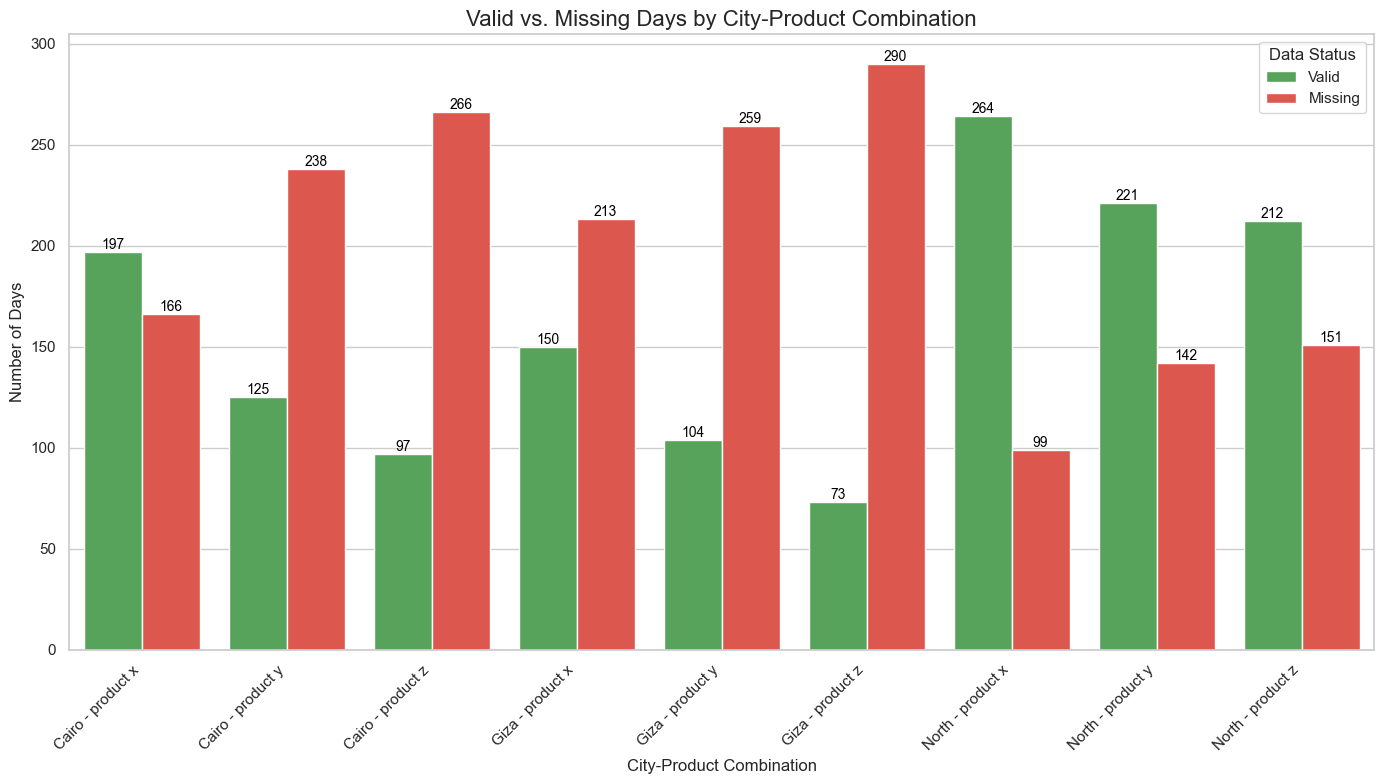

In [152]:
analysis_df_long = pd.melt(
    analysis_df,
    id_vars=['city', 'product'],
    value_vars=['valid_days', 'missing_days'],
    var_name='Data Status',
    value_name='Days'
)

analysis_df_long['Data Status'] = analysis_df_long['Data Status'].replace({
    'valid_days': 'Valid',
    'missing_days': 'Missing'
})

analysis_df_long['city_product'] = analysis_df_long['city'] + ' - ' + analysis_df_long['product']

plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Plot grouped bars
ax = sns.barplot(
    x='city_product',
    y='Days',
    hue='Data Status',
    data=analysis_df_long,
    palette={'Valid': '#4CAF50', 'Missing': '#F44336'},
    errorbar=None
)

# Customize labels and titles
plt.title('Valid vs. Missing Days by City-Product Combination', fontsize=16)
plt.xlabel('City-Product Combination', fontsize=12)
plt.ylabel('Number of Days', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for readability

# Add annotations (optional)
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
        textcoords='offset points'
    )

plt.legend(title='Data Status', loc='upper right')
plt.tight_layout()
plt.show()

### 3.5 Analyzing Missing Data in the Last N Days

In this step, we visualize the missing data for specific city-product combinations over the last **N** days. The goal is to identify and highlight missing values (NaNs) in the time series, which are filled with zeros for clarity.  
  
This analysis helps identify areas where the data is incomplete, so further cleaning or imputation can be performed  

In [153]:
import matplotlib.dates as mdates
import matplotlib.patches as patches

def draw_nan(df, city, product, last_days=100):
    # Filter and prepare data
    df = df.copy()
    df = df.set_index('time_step', drop=True)
    df.index = pd.to_datetime(df.index)
    
    # Get global date range
    global_start = df.index.min()
    global_end = df.index.max()
    full_date_range = pd.date_range(start=global_start, end=global_end, freq='D')

    filtered_df = df.query("city == @city & product_name == @product")
    filtered_df.index = pd.to_datetime(filtered_df.index)
    
    # Resample to daily frequency
    resampled = filtered_df['quantity'].resample('D').mean().reindex(full_date_range)
    
    missing_percent = resampled.isna().sum() / len(resampled)
    
    # Get last N days
    resampled = resampled.iloc[-last_days:]
    start_date = resampled.index[0].date()
    end_date = resampled.index[-1].date()
    missing_mask = resampled.isna()

    # Create filled version with zeros for missing values
    filled = resampled.fillna(0)
    
    _, ax = plt.subplots(figsize=(14, 5))
    
    # Plot the filled data
    ax.plot(filled.index, filled, 
            color='#1f77b4', 
            marker='o',
            markersize=6,
            linestyle='-', 
            linewidth=1.5,
            label='Valid Data')
    
    # Highlight missing days (zeros that were originally NaN)
    missing_dates = filled[missing_mask].index
    ax.scatter(missing_dates, 
            filled[missing_mask], 
            color='red', 
            marker='X',
            s=100,
            zorder=3,
            label='Missing Days (filled with 0)')
    
    # Formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=max(1, len(resampled)//10)))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add visual elements
    ax.set_title(
        f"Last {last_days} Days: {city} - {product}\n"
        f"({start_date} to {end_date}, Data Missing percentage: {missing_percent:.1%})",
        pad=20
    )
    ax.set_xlabel("Date", labelpad=10)
    ax.set_ylabel("Average Quantity", labelpad=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Create custom legend
    legend_elements = [
        patches.Patch(facecolor='#1f77b4', label='Valid Data'),
        patches.Patch(facecolor='red', label='Missing Days (filled with 0)')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

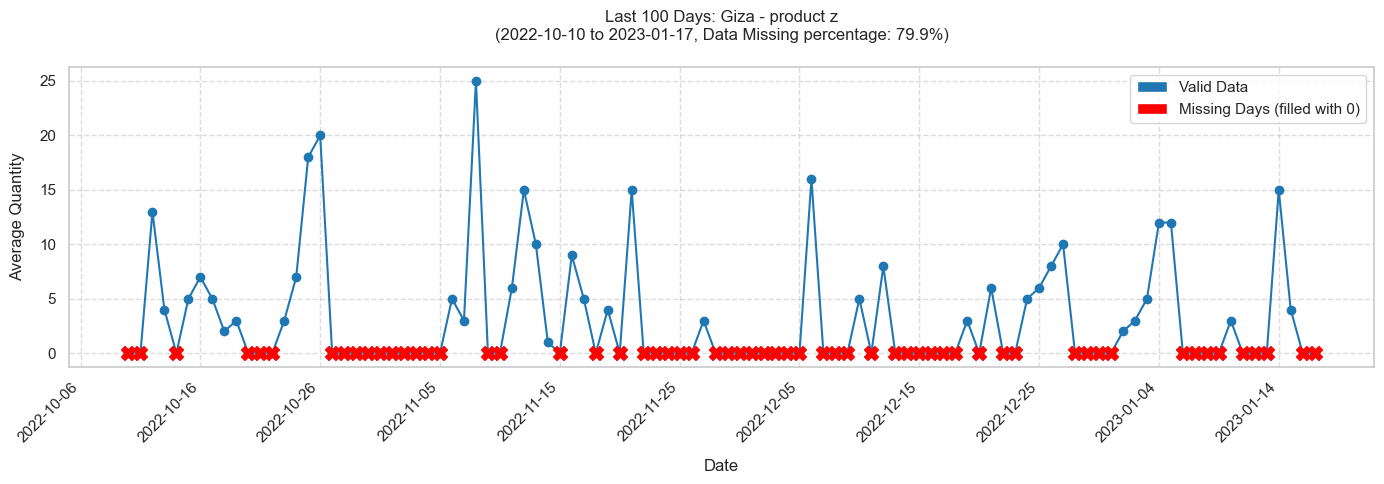

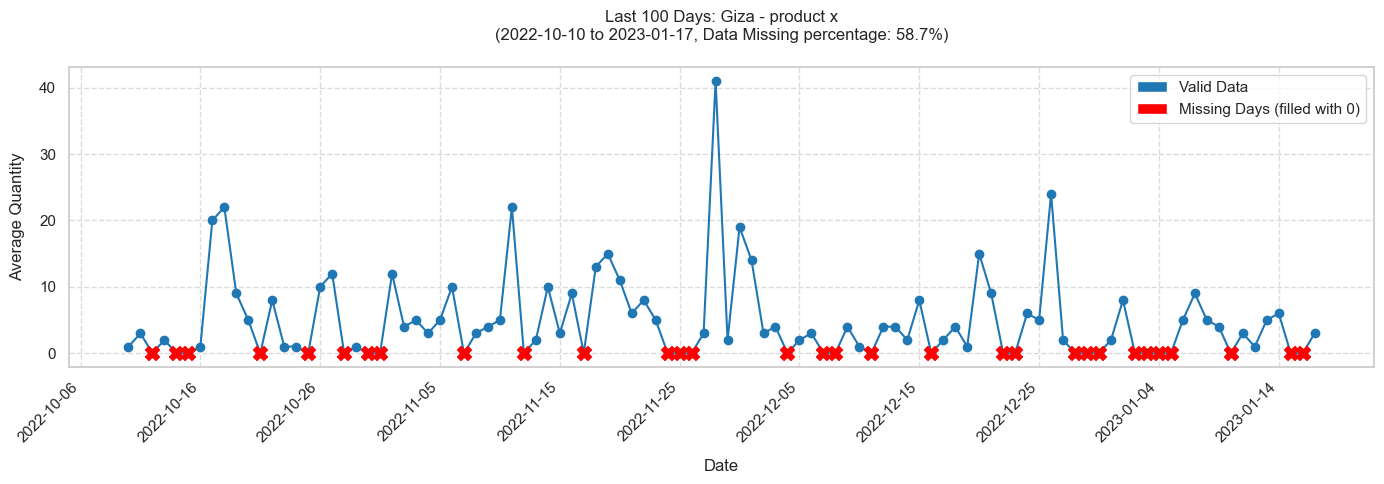

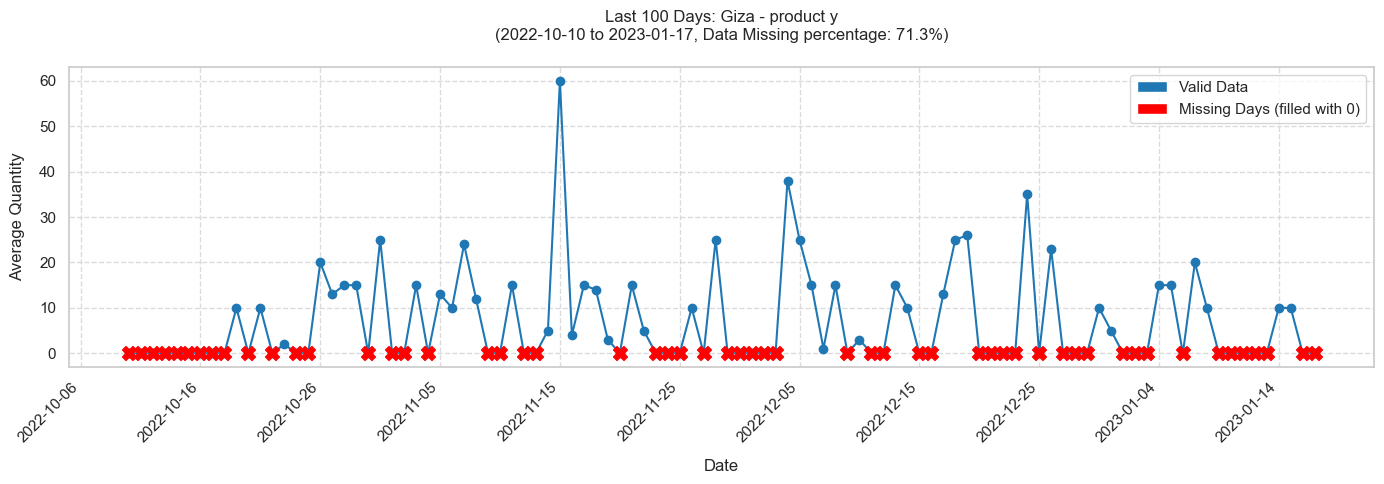

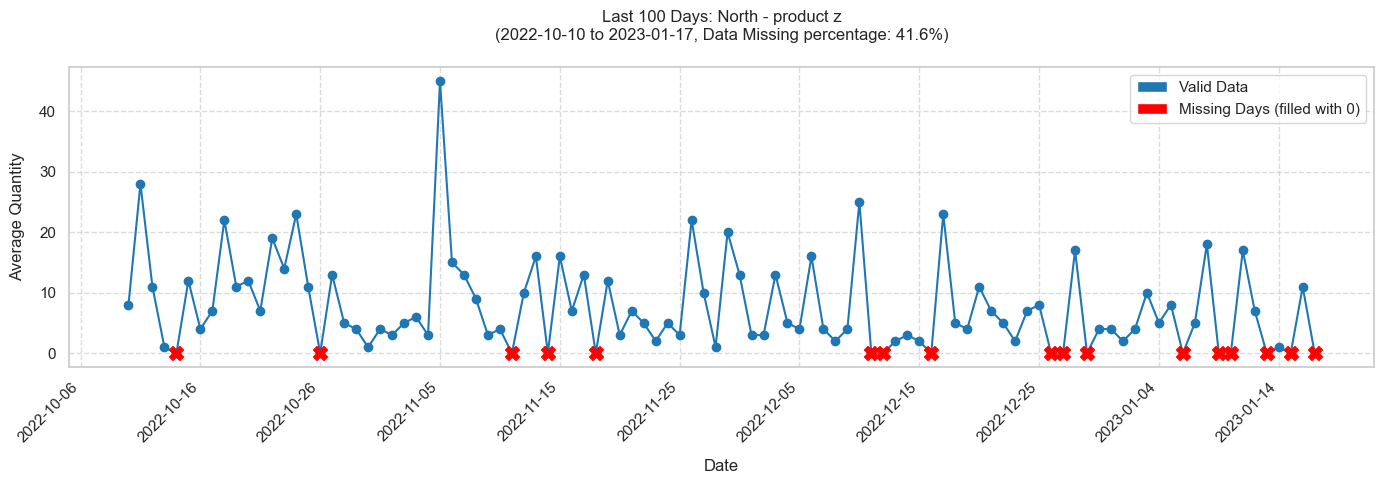

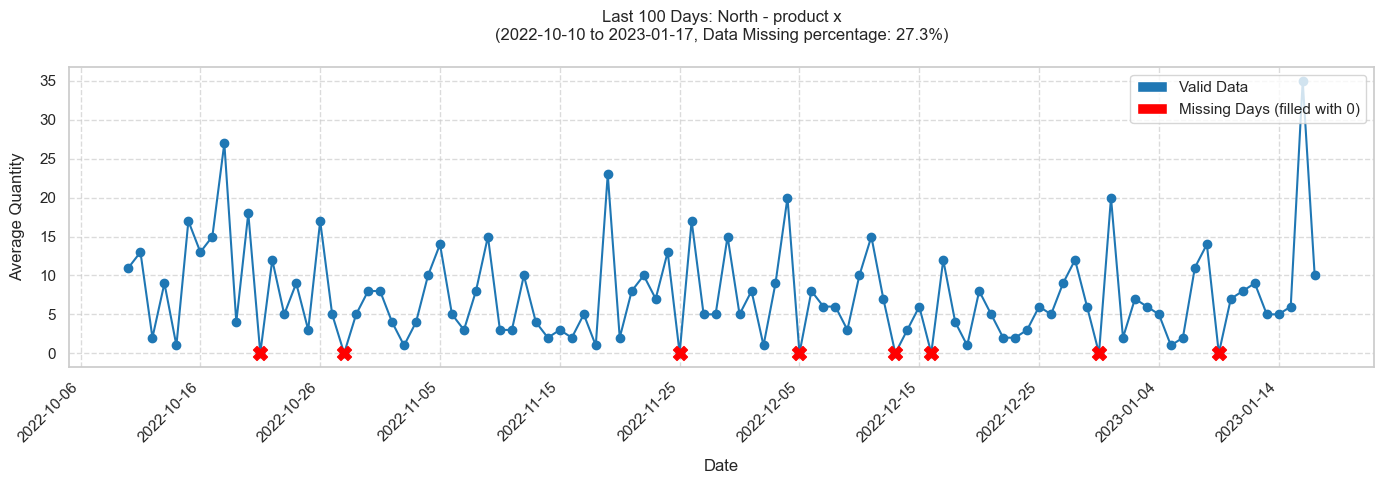

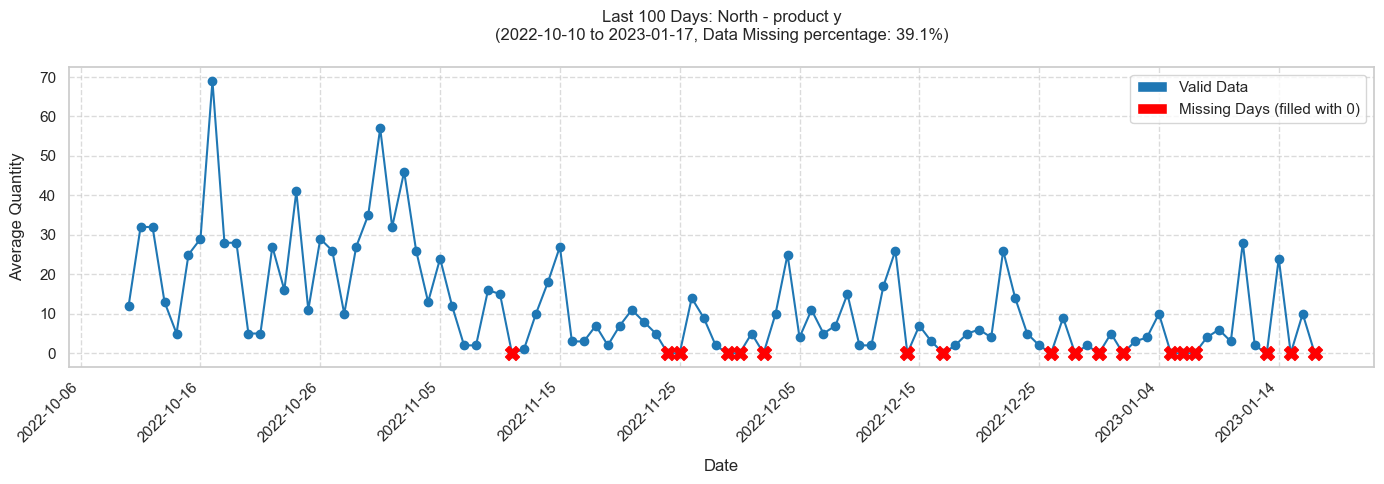

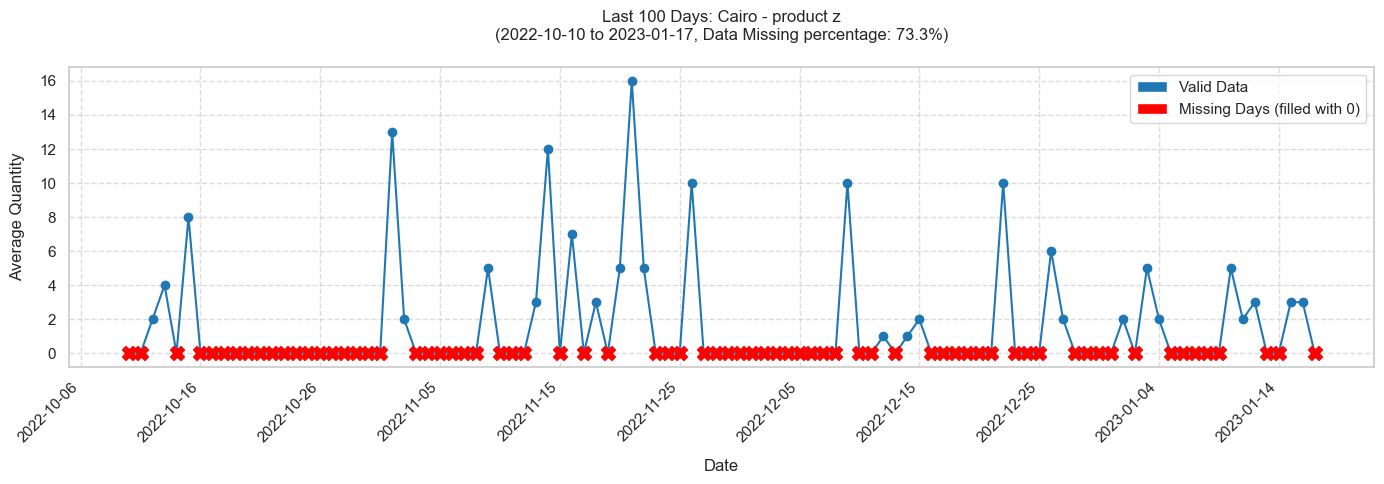

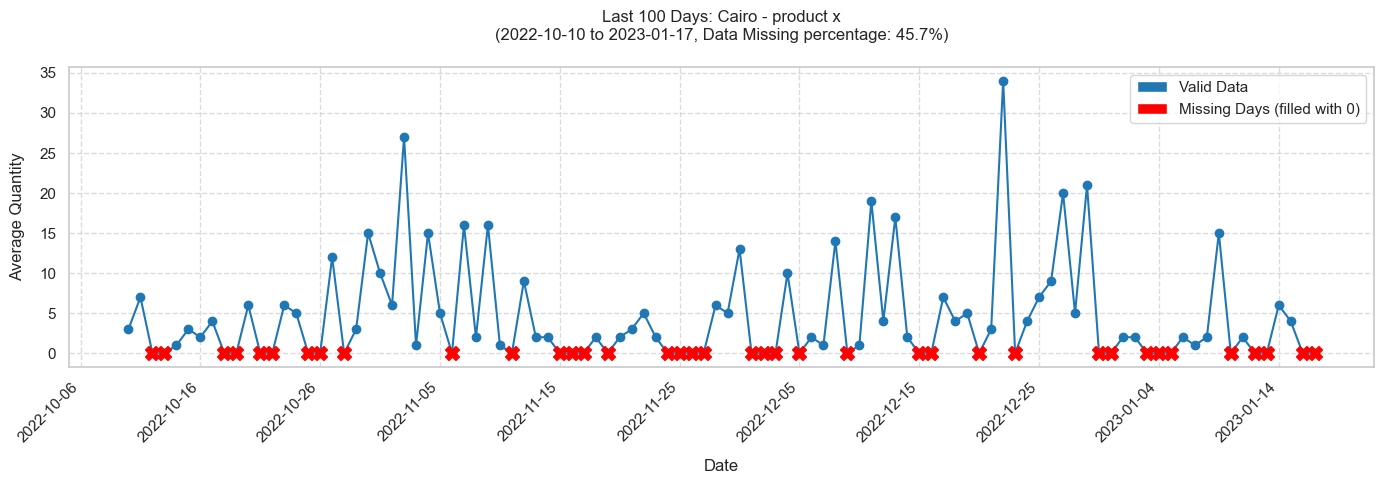

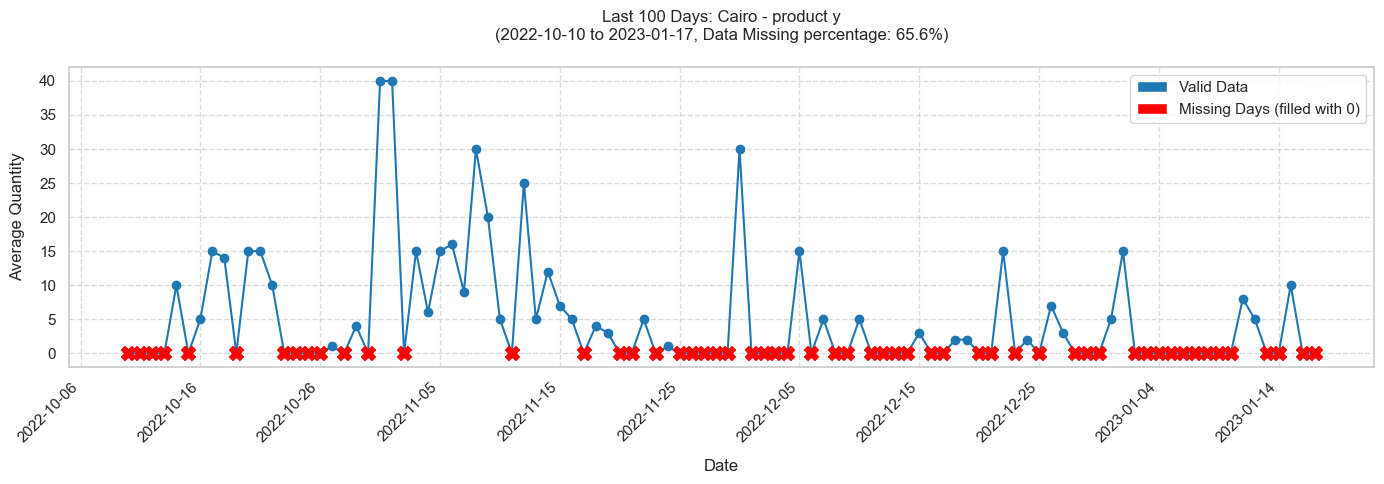

In [154]:
for city in df.city.unique():
    for product in df.product_name.unique():
        # Get analysis results without printing/plotting
        stats = draw_nan(df_grid, city, product)

# 4. Feature Engineering

In this section, we focus on creating new features from the existing data to improve the performance of machine learning models. Feature engineering involves transforming raw data into meaningful features that capture important patterns and trends.

We will utilize the helper function `create_complete_grid()` to generate a complete time-step-product-city grid. This ensures that our data is consistent and includes all combinations of time, city, and product, filling any missing values where necessary.

### 4.1 Remove Outliers According to Quantity

In this step, we focus on identifying and removing outliers in the dataset based on the `quantity` feature. Outliers can skew the results and negatively impact the performance of machine learning models. To address this, we use the **Interquartile Range (IQR)** method to detect outliers.  

In [155]:
def detect_outliers(df, check_cols, threshold=1.5):
    df_out = df.copy()
    outlier_flags = pd.Series(False, index=df.index)  # Initialize all flags to False
    group_cols = ['city','product_name']
    for col in check_cols:
        # Calculate quartiles and IQR for each group
        q1 = df.groupby(group_cols)[col].transform(lambda x: x.quantile(0.25))
        q3 = df.groupby(group_cols)[col].transform(lambda x: x.quantile(0.75))
        iqr = q3 - q1
        
        # Determine outlier bounds
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        
        # Identify outliers for the current column
        col_outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_flags |= col_outliers  # Combine with previous flags using OR
    
    df_out['is_outlier'] = outlier_flags
    return df_out

We use the `detect_outliers()` function to apply this method, and outliers are flagged and removed from the dataset. After cleaning the data, we apply the `create_complete_grid()` function to generate a full time-step-product-city grid, ensuring consistency across all combinations.

This process ensures that extreme values in the `quantity` column do not interfere with further analysis or modeling.

In [156]:
df_grid_cleaned = detect_outliers(df_grid.dropna(), ['quantity'],threshold=2.0)
df_grid_cleaned = df_grid_cleaned[df_grid_cleaned['is_outlier']==0]
df_grid = create_complete_grid(df_grid_cleaned)

### 4.2 Time Series Feature Engineering

In this step, we enrich the dataset by creating time-series features that capture temporal dependencies and seasonality. This is essential for improving the model's ability to learn time-based patterns.

The **`time_series_feature()`** function performs the following transformations:

1. **Time-Related Features**:
   - **Day of the Week**: Encoded as an integer (Monday = 0, Sunday = 6).
   - **Month**: Extracted from the `time_step` column.
   - **Week of the Year**: Calculated using `isocalendar().week`.
   - **Day of the Year**: Indicates the day number in the calendar year.
   - **Sine and Cosine Transformations**: Applied to the day of the week to capture its cyclic nature.
   - **Is Holiday**: Flags Fridays (day 4) as holidays — this is a placeholder and can be extended for real holidays.

2. **Missingness Feature**:
   - **`is_missing`**: A binary indicator that marks whether the `quantity` value is missing. This helps models identify patterns of missingness.

3. **Optional Interpolation for Missing Data**:
   - When `use_interpolation=True`, missing values in the `quantity` column are optionally filled with 0. The number of values to fill depends on the missing rate:
     - **High Fill Rate**: If missingness exceeds a given threshold.
     - **Low Fill Rate**: If missingness is below the threshold.
   - Additionally, missing values in `discount` and `unit_price` are forward-filled using the last known value.

4. **Rolling Features**:
   - **Rolling Averages**: Computed for the `quantity` column over windows of 7, 14, and 30 days. These are shifted by 1 to prevent information leakage from future values.

5. **Lag Features**:
   - **Lag Features for `quantity`, `discount`, and `unit_price`**: Created for each group (`city`, `product_name`) to capture short-term historical trends (e.g., `q_(t-1)`, `p_(t-2)`).
   - These features enable the model to learn temporal dependencies crucial for forecasting.

After feature generation, the initial rows containing NaN values due to lagging are dropped. This ensures the training data contains only complete rows.

> **Note:**  
> ***The `area` column was dropped*** for the following reasons:
> 1. The primary goal is to forecast at the **city** level, and `area` is a more granular feature not relevant for aggregation.
> 2. Feature importance analysis using a trained LightGBM model showed that `area` contributed very little, so removing it simplifies the pipeline without sacrificing performance.

In [157]:
def time_series_feature(df, lags_q, lags_d, lags_p, rolling_by,use_interpolation=False):
    # Create complete time_step grid for all groups
    df = df.copy()
    df['time_step'] = pd.to_datetime(df['time_step'])
    all_dates = pd.date_range(df['time_step'].min(), df['time_step'].max(), freq='D')
    groups = df.groupby(['city', 'product_name'])
    
    processed = []
    for (city, product_name), group in groups:
        # Reindex to complete time_step range
        group = group.set_index('time_step').reindex(all_dates)
        group['city'] = city
        group['product_name'] = product_name
        
        # Reset index to get time_step column back
        group = group.reset_index().rename(columns={'index': 'time_step'})
        
        # Feature engineering
        # 1 - time feature
        #      'day_of_week' is {'0': Monday, ...., '4': Friday, ....} 
        group['day_of_week'] = group['time_step'].dt.dayofweek  
        group['month'] = group['time_step'].dt.month
        group['week'] = group['time_step'].dt.isocalendar().week # Week of the year
        group['day_of_year'] = group['time_step'].dt.dayofyear
        group['day_of_week_sin'] = np.sin(2 * np.pi * group['day_of_week'] / 7)
        group['day_of_week_cos'] = np.cos(2 * np.pi * group['day_of_week'] / 7)
        
        # ---------> More future work ---------> add 5 Friday and Saturday
        group['is_holiday'] = group['day_of_week'].isin([4]).astype(int) 
        # Create missing indicator
        group['is_missing'] = group['quantity'].isna().astype(int)
        

        # ---------> More future work --------->
        if use_interpolation:
            threshold=0.4, 
            high_missing_fill=0.3 
            low_missing_fill=0.8
            
            missing_mask = group['quantity'].isna()
            missing_count = missing_mask.sum()
            group_size = len(group)
            missing_rate = missing_count / group_size if group_size > 0 else 0
            
            if missing_count > 0:
                # Determine fill probability based on missing rate
                fill_prob = high_missing_fill if missing_rate >= threshold else low_missing_fill
                # Calculate number of values to fill
                n_fill = int(fill_prob * missing_count)

                if n_fill > 0:
                    # Get indices of missing values
                    missing_indices = group[missing_mask].index
                    
                    # Randomly select values to fill
                    fill_indices = np.random.choice(missing_indices, 
                                                size=n_fill, 
                                                replace=False)
                    
                    # Fill selected missing values with 0
                    group.loc[fill_indices, 'quantity'] = 0
                                
            
            
            missing_mask = group['quantity'].isna()

            missing_rate = missing_mask.sum() / len(group)
            missing_indices = group[missing_mask].index
            n_fill = int((1-0.5) * missing_rate * len(missing_indices))

            random_fill_indices = np.random.choice(missing_indices, size=n_fill, replace=False)
            group.loc[random_fill_indices, 'quantity'] = 0

            group[['discount','unit_price']] = group[['discount','unit_price']].fillna(method = 'ffill')
        
        # Time-aware rolling features (7-day window) use .shift prevent future leakage
        for roll in rolling_by:
            group[f'rolling_{roll}d_avg'] = group['quantity'].rolling(
                window=roll, 
                min_periods=1).mean().shift(1)
    
        # Create lag features (handling missingness)
        for lag in lags_q:
            group[f'q_(t-{lag})'] = group['quantity'].shift(lag)
        for lag in lags_d:
            group[f'd_(t-{lag})'] = group['discount'].shift(lag)
        for lag in lags_p:
            group[f'p_(t-{lag})'] = group['unit_price'].shift(lag)
        
        # I will remove the first max_lagged beacuse it will be NAN
        max_lag = max(max(lags_q), max(lags_d), max(lags_p))
        group = group.iloc[max_lag:]

        processed.append(group)
    
    return pd.concat(processed).reset_index(drop=True)

In [158]:
lags_quantity = range(1,8) 
lags_price = [1,2]
lags_discount = range(1,8)

rolling_by = [7,14,30]

In [159]:
prepared_df = time_series_feature(df_grid, lags_quantity, lags_discount, lags_price,
                                  rolling_by, use_interpolation=True)

***Removing Rows with Missing Target Values***

In this step, we drop rows from the dataset where the target variable, `quantity`, is missing.  
  
This is crucial for ensuring that the model is trained only on complete data, where the target variable is available.


In [160]:
# Drop rows with missing in target
prepared_df = prepared_df[~prepared_df['quantity'].isna()].reset_index(drop=True)

***Removing Rows with Excessive Missing Values***

Filter out rows where the number of missing values exceeds a specified threshold (in this case, more than 10 missing values).  
    
This helps maintain the integrity of the dataset by eliminating rows with too many missing values that might negatively impact model training.

In [161]:
# drop rows with misiing more than 10
prepared_df = prepared_df[prepared_df.isna().sum(axis=1)<=10]

In [162]:
def city_product_df(df, city, product):
    df = df.copy()
    return df.query("city == @city & product_name == @product").reset_index(drop=True)

In [163]:
size_df, num_features = prepared_df.shape
print(f"Number of missing quantity (Target): {prepared_df['is_missing'].sum()}")
print(f"Overall missing percentage: {prepared_df['is_missing'].sum() / size_df :.2%}")
# 55.06% is huge missing percetage

Number of missing quantity (Target): 832
Overall missing percentage: 37.56%


# 5. Prepare Data for training

### 5.1 Prepare Features and Target

In this step, we perform data preprocessing to prepare for model training:  

1. **Dropping the `is_missing` Column**  
   The `is_missing` column is no longer needed, as we have already dropped the rows where `quantity` is missing. This column would be useful if we were to interpolate missing values in the `quantity` column, but it is removed before further steps.

2. **Handle Categorical Columns**  
   LightGBM, a gradient boosting framework, is optimized to work efficiently with categorical features when they are explicitly marked as `category` type. This conversion ensures that LightGBM can handle categorical columns such as `city`, `product_name`, `day_of_week`, and `month` appropriately.

3. **Split Features and Target Variable**  
   The feature set `X` is created by removing the `quantity` (target variable) and `time_step` columns, leaving only the relevant features for model training. The target variable `y` is the `quantity` column, which we aim to predict.

4. **Handle Missing Values**  
   We do not explicitly handle missing values in columns other than `quantity` because LightGBM can automatically manage missing data during training. As a result, we leave the remaining columns with missing values intact, trusting LightGBM's built-in handling.

With these steps, the dataset is now ready for training with LightGBM, where categorical columns are appropriately encoded, and missing values are left for LightGBM to handle.


In [164]:
# Drop is_missing it
prepared_df = prepared_df.drop(columns='is_missing')

# Create an explicit copy of your DataFrame first
df_ml = prepared_df.copy()

# Sort by time_steps
df_ml = df_ml.sort_values('time_step').reset_index(drop=True)

categorical_cols = ['city', 'product_name', 'day_of_week', 'month']

df_ml[categorical_cols] = df_ml[categorical_cols].astype('category')

X = df_ml.drop(['quantity', 'time_step'], axis=1)
y = df_ml['quantity']


In [165]:
print("Input features name : ")
print(X.columns.to_list())

Input features name : 
['city', 'product_name', 'discount', 'unit_price', 'day_of_week', 'month', 'week', 'day_of_year', 'day_of_week_sin', 'day_of_week_cos', 'is_holiday', 'rolling_7d_avg', 'rolling_14d_avg', 'rolling_30d_avg', 'q_(t-1)', 'q_(t-2)', 'q_(t-3)', 'q_(t-4)', 'q_(t-5)', 'q_(t-6)', 'q_(t-7)', 'd_(t-1)', 'd_(t-2)', 'd_(t-3)', 'd_(t-4)', 'd_(t-5)', 'd_(t-6)', 'd_(t-7)', 'p_(t-1)', 'p_(t-2)']


### 5.2 Time-Based Train/Validation/Test Split

In this step, we split the dataset chronologically into training, validation, and test sets using the following proportions:

- **70% Training**
- **20% Validation**
- **10% Test**

Steps:
1. Calculate the total number of observations.
2. Compute split indices based on the desired proportions.
3. Get split dates using the `time_step` column.
4. Create boolean masks to split the dataset by date.
5. Slice the features and target variables using these masks.
6. Concatenate `X_train` and `X_val` into `X_train_val` (same for `y`) to use for hyperparameter tuning in RandomizedSearchCV.

Finally, the dataset is split into three parts while maintaining temporal order, which is essential for time series modeling.


In [166]:
# Total number of observations
total_size = len(df_ml)

# Calculate sizes for each split
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size  # Should be 10%

# Get split dates
split_date_val = df_ml.iloc[train_size]['time_step']        # 70% mark
split_date_test = df_ml.iloc[train_size + val_size]['time_step']  # 90% mark

# Training set: Everything before the validation split date
train_mask = df_ml['time_step'] < split_date_val

# Validation set: Between validation and test split dates
val_mask = (df_ml['time_step'] >= split_date_val) & (df_ml['time_step'] < split_date_test)

# Test set: Everything after the test split date
test_mask = df_ml['time_step'] >= split_date_test

X_train, y_train = X.loc[train_mask] , y.loc[train_mask]
X_val,   y_val   = X.loc[val_mask]   , y.loc[val_mask]
X_test,  y_test  = X.loc[test_mask]  , y.loc[test_mask]

# This will used in Random search
X_train_val = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_train_val = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

print(f"Training size: {train_mask.sum()} ({train_mask.sum() / total_size:.1%})")
print(f"Validation size: {val_mask.sum()} ({val_mask.sum() / total_size:.1%})")
print(f"Test size: {test_mask.sum()} ({test_mask.sum() / total_size:.1%})")

Training size: 1548 (69.9%)
Validation size: 443 (20.0%)
Test size: 224 (10.1%)


# 6. Model

In [2]:
from lightgbm import LGBMRegressor
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

### 6.1 Hyperparameter Tuning using Randomized Search

In this step, we perform hyperparameter optimization using `RandomizedSearchCV` for the LightGBM regressor. The following steps are executed:

1. Initialize the LightGBM regressor with base parameters (using `dart` boosting).
2. Define a parameter grid with potential values for tuning.
3. Set up `RandomizedSearchCV` to search across 50 random combinations with 3-fold cross-validation.
4. Fit the randomized search on the combined training and validation set (`X_train_val`, `y_train_val`).
5. Output the best hyperparameters and the corresponding CV score.


In [168]:
# Initialize regressor with proper parameters
mdl = LGBMRegressor(
    boosting_type='dart',
    metric= ['rmse', 'mae'],
    objective='regression',
    n_jobs=-1,
    verbose=-1,
    force_col_wise =True,
)
# To view the default model parameters:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'subsample', 'subsample_for_bin', 'subsample_freq', 'metric', 'verbose', 'force_col_wise'])

In [169]:
randomized_search_params = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "num_leaves": [20, 31, 50, 70, 100, 150],
    "max_depth": [-1, 5, 10, 15],
    "n_estimators": [100, 200, 500, 1000],
    "feature_fraction": [0.6, 0.7, 0.8, 0.9, 1.0],
    "bagging_fraction": [0.5, 0.6, 0.7, 0.8, 1.0],
    "bagging_freq": [1, 5, 10],
    "min_data_in_leaf": [1, 5, 10, 20, 50],
    "lambda_l1": [0.0, 0.1, 1.0, 10.0],
    "lambda_l2": [0.0, 0.1, 1.0, 10.0],
    "min_gain_to_split": [0.0, 0.1, 0.5, 1.0],
    "subsample": [0.5, 0.6, 0.7, 0.8, 1.0]
}

randomized_search = RandomizedSearchCV(
    mdl,
    param_distributions=randomized_search_params,
    n_iter=50,  # Test only 50 random combinations
    cv=3,
    n_jobs=-1
)
# grid = GridSearchCV(mdl, gridParams, verbose=1, cv=3, n_jobs=-1)

In [170]:
# Run the randomized search 
randomized_search.fit(X_train_val, y_train_val)

# Print the best parameters found
print(randomized_search.best_params_)
print(randomized_search.best_score_)

{'subsample': 0.5, 'num_leaves': 70, 'n_estimators': 1000, 'min_gain_to_split': 0.5, 'min_data_in_leaf': 1, 'max_depth': 10, 'learning_rate': 0.01, 'lambda_l2': 0.0, 'lambda_l1': 0.0, 'feature_fraction': 0.9, 'bagging_freq': 1, 'bagging_fraction': 0.7}
0.07851677016389298


### 6.2 Prepare LightGBM Datasets

This step prepares the data for LightGBM training:

1. Create the training dataset, specifying categorical features.
2. Create the validation dataset, referencing the training dataset to preserve categorical encoding.


In [171]:
# Training data
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical_cols,
    free_raw_data=False
)

# Validation data (for early stopping)
val_data = lgb.Dataset(
    X_val,
    label=y_val,
    reference=train_data  # Maintains categorical encoding from training
)

### 6.3 Train LightGBM Model

1. Retrieve the best parameters from the randomized search.
2. Add additional parameters for LightGBM training.
3. Train the model with the training and validation datasets, using early stopping and logging evaluation metrics.


In [172]:
params = randomized_search.best_params_

param_add = {
    'objective': 'regression',
    'metric': ['rmse', 'mae'],
    'boosting_type': 'dart',
    'verbose': -1,
    'force_row_wise': True
    }

params = params | param_add

In [173]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # More aggressive early stopping
        lgb.log_evaluation(50)
    ]
)

c:\Users\AMstore\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\AMstore\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[50]	training's rmse: 4.54159	training's l1: 3.24895	valid_1's rmse: 7.39958	valid_1's l1: 5.29669
[100]	training's rmse: 4.49653	training's l1: 2.93559	valid_1's rmse: 7.58439	valid_1's l1: 5.34137
[150]	training's rmse: 4.41997	training's l1: 2.81686	valid_1's rmse: 7.58301	valid_1's l1: 5.33586
[200]	training's rmse: 4.16592	training's l1: 2.66998	valid_1's rmse: 7.41498	valid_1's l1: 5.29021
[250]	training's rmse: 3.92603	training's l1: 2.54412	valid_1's rmse: 7.27499	valid_1's l1: 5.27208
[300]	training's rmse: 3.66835	training's l1: 2.42721	valid_1's rmse: 7.13655	valid_1's l1: 5.29897
[350]	training's rmse: 3.53915	training's l1: 2.35572	valid_1's rmse: 7.0702	valid_1's l1: 5.30113
[400]	training's rmse: 3.25289	training's l1: 2.22479	valid_1's rmse: 6.99976	valid_1's l1: 5.34494
[450]	training's rmse: 3.02381	training's l1: 2.1052	valid_1's rmse: 6.98573	valid_1's l1: 5.38742
[500]	training's rmse: 2.87683	training's l1: 2.02392	valid_1's rmse: 6.98794	valid_1's l1: 5.41501
[55

### 6.4 Model Evaluation and Visualization

1. **Evaluate the model's performance** by calculating RMSE and MAE on the test set.
2. **Plot predictions** using the `plot_predictions()` function, which visualizes the actual vs predicted quantities for each city-product combination.
3. **Generate plots** for all unique city-product pairs in the dataset.

> **Note:**  
> This evaluation and visualization focus on predicting for only 1 day. Our target is to predict 10 days into the future, which has not yet been achieved.

In [174]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f'\nTest RMSE: {rmse:.2f}')
print(f'Test MAE: {mae:.2f}')


Test RMSE: 6.25
Test MAE: 4.57


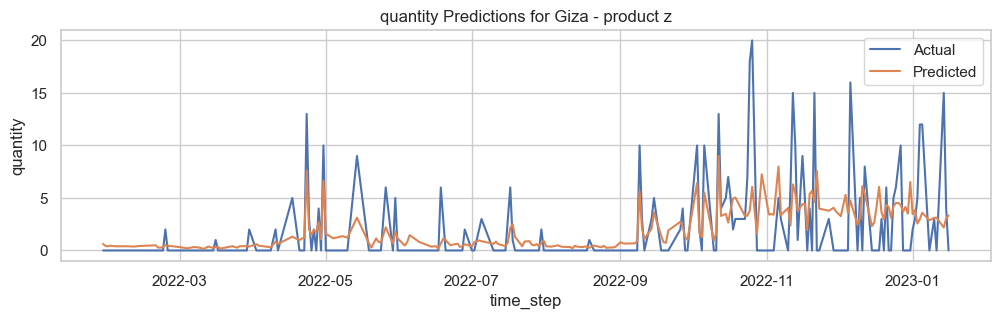

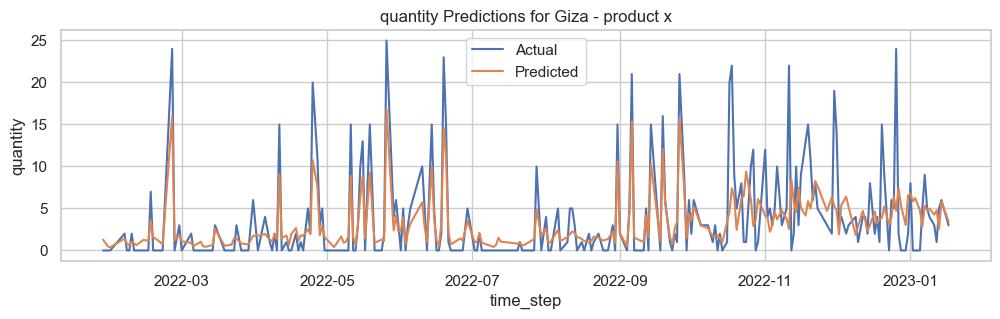

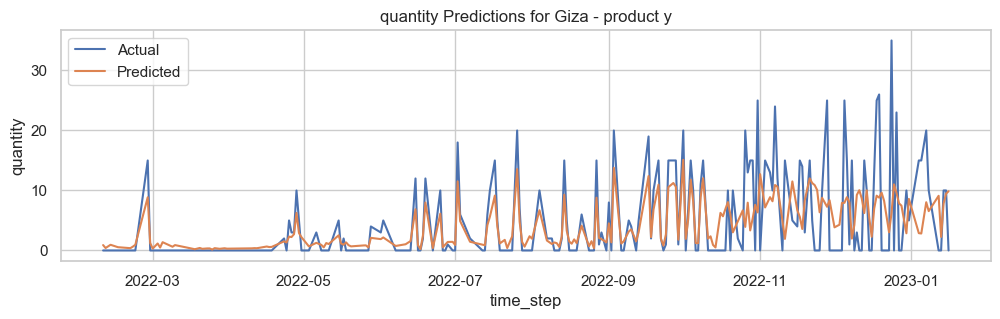

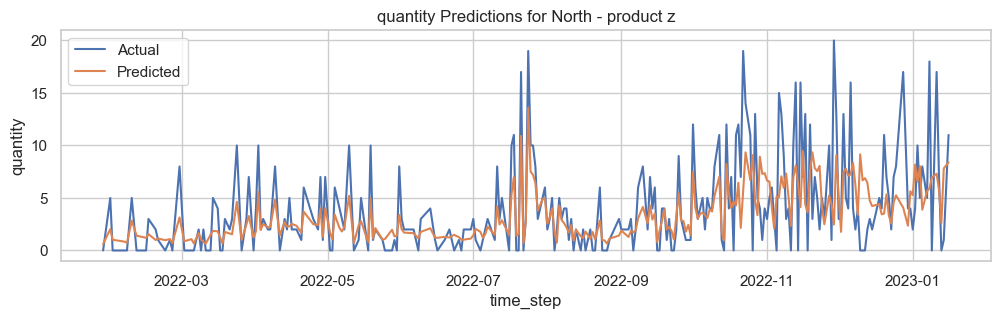

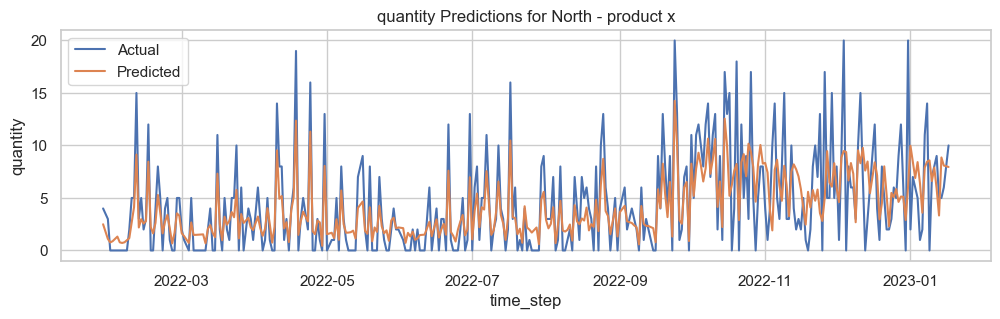

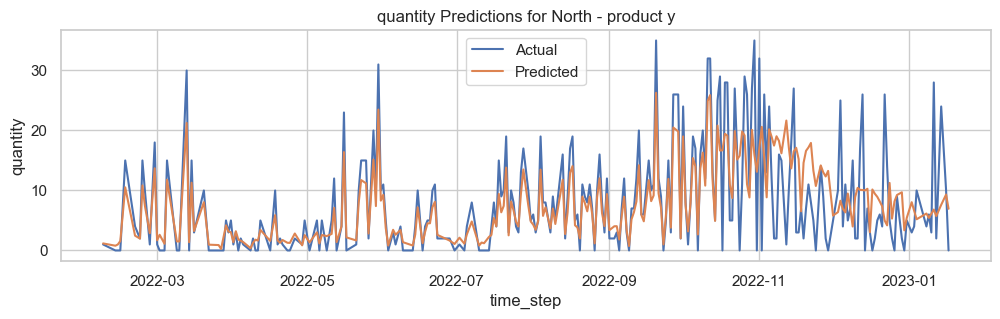

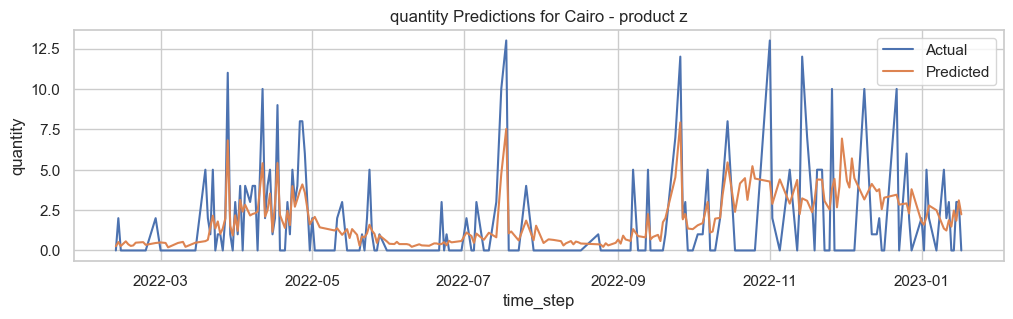

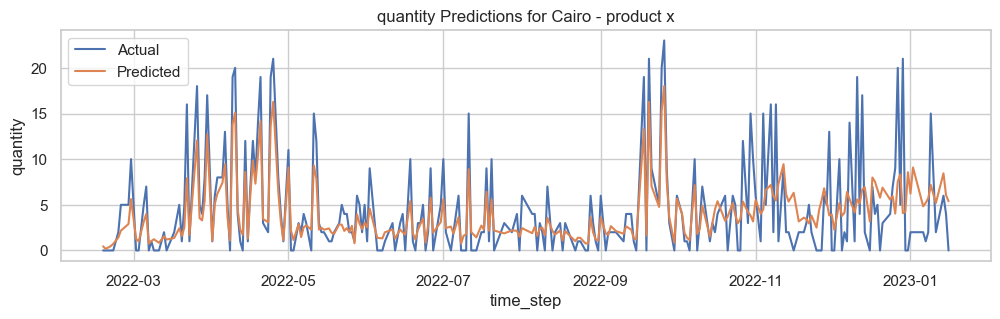

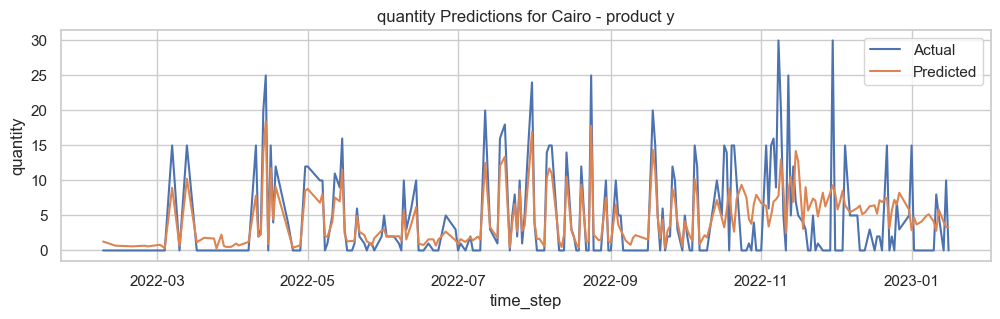

In [175]:
def plot_predictions(X, y, y_pred, city, product_name):
    mask = (X['city'] == city) & (X['product_name'] == product_name)
    dates = df_ml['time_step'][mask]
    plt.figure(figsize=(12, 3))
    plt.plot(dates, y[mask], label='Actual')
    plt.plot(dates, y_pred[mask], label='Predicted', zorder = 4)
    plt.title(f'quantity Predictions for {city} - {product_name}')
    plt.xlabel('time_step')
    plt.ylabel('quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example plot for one product_name-city combination
y_pred_all = model.predict(X)
for c in df_original.city.unique():
    for p in df_original.product_name.unique():
        plot_predictions(X=X,y=y,y_pred=y_pred_all, city=c, product_name=p)

### 6.5 Show the feature importance

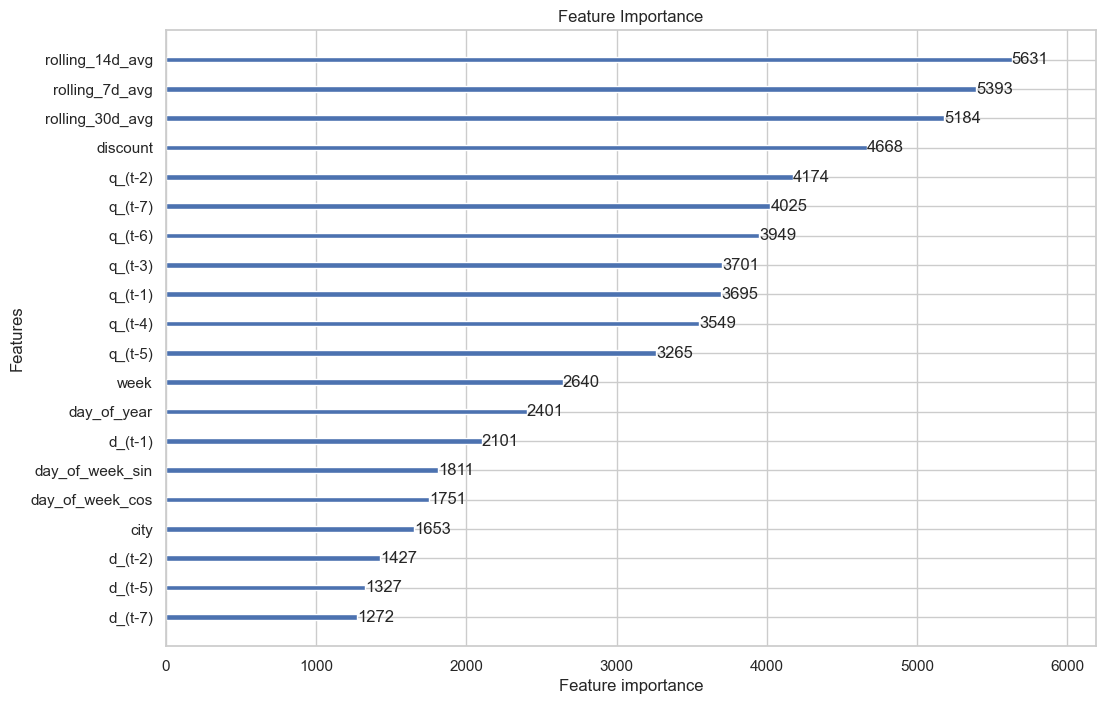

In [176]:
# Feature importance
lgb.plot_importance(model, figsize=(12, 8), max_num_features=20)
plt.title('Feature Importance')
plt.show()

# 7. Predicting the 10-Day Horizon from Any Given Day

### 7.1 Autoregressive Prediction Function

1. **Filter data**: Extract relevant data for the specified city and product from the input DataFrame.
2. **Set start date for prediction**: If no start date is provided, use the last available date in the data plus one day.
3. **Prepare previous data**: Create a DataFrame with the data from `max_lag` days before the prediction start date.
4. **Generate prediction dates**: Create a date range for the prediction horizon (default: 10 days).
5. **Create feature columns**: Add features like `day_of_week`, `month`, `week`, `day_of_year`, and holiday indicator.
6. **Prepare data for prediction**: Merge historical data with the prediction dates and ensure categorical variables are encoded.
7. **Handle missing values**: Fill missing values for `discount` and `unit_price` with their respective means.
8. **Loop over the prediction horizon**: For each day in the prediction range:
   - Extract features (lags and rolling averages) for the day.
   - Predict the quantity for the day using the trained model.
   - Update the predicted values in the DataFrame.
9. **Generate actual quantity**: Calculate actual quantities for the prediction period based on historical data.
10. **Return final prediction DataFrame**: Merge actual and predicted quantities and return the result.

In [177]:
def autoregressive_prediction(df, city, product, lags_q, lags_d, lags_p, rolling_by,start_pred_date=None, horizon=10, max_lag=7, take_last=20):
    df_city_product = df[(df['city'] == city) & (df['product_name'] == product)].copy()
    df_city_product['time_step'] = pd.to_datetime(df_city_product['time_step'])

    # if date given start pred from this date else start from last date + 1
    if start_pred_date is None:
        start_pred_date = df_city_product.iloc[-1]['time_step'] + pd.Timedelta(days=1)
    start_pred_date = pd.to_datetime(start_pred_date)
    start_prev_date = start_pred_date - pd.Timedelta(days=max_lag)

    # Filter the DataFrame
    prev_df = df_city_product[
        (df_city_product['time_step'] >= start_prev_date) &
        (df_city_product['time_step'] < start_pred_date)].sort_values('time_step').reset_index(drop=True) 
    prev_df.rename(columns={'quantity': 'predicted_quantity'}, inplace=True)
    prev_df['time_step'] = pd.to_datetime(prev_df['time_step'])
    prev_full_date = pd.date_range(start=start_prev_date, end=start_pred_date - pd.Timedelta(days=1), freq='D')

    df_complete = pd.DataFrame({'time_step': prev_full_date})
    prev_df = df_complete.merge(prev_df,on='time_step',how='left')  

    # next_dates = pd.date_range(start=start_day_of_pred, end=next_end, freq='D')

    end_date = start_pred_date + pd.Timedelta(days=horizon - 1)
    pred_dates = pd.date_range(start=start_pred_date, end=end_date, freq='D')

    prediction_data = pd.DataFrame({'time_step':pred_dates}, columns=prev_df.columns)
    prediction_data['time_step'] = pd.to_datetime(prediction_data['time_step'])
    prediction_data['city'] = city
    prediction_data['product_name'] = product
    prediction_data['day_of_week'] = prediction_data['time_step'].dt.dayofweek  
    prediction_data['month'] = prediction_data['time_step'].dt.month
    prediction_data['week'] = prediction_data['time_step'].dt.isocalendar().week # Week of the year
    prediction_data['day_of_year'] = prediction_data['time_step'].dt.dayofyear
    prediction_data['day_of_week_sin'] = np.sin(2 * np.pi * prediction_data['day_of_week'] / 7)
    prediction_data['day_of_week_cos'] = np.cos(2 * np.pi * prediction_data['day_of_week'] / 7)
    prediction_data['is_holiday'] = prediction_data['day_of_week'].isin([4]).astype(int) 

    # Concatinate prev with future
    prediction_data = pd.concat([prev_df, prediction_data], ignore_index=True)

    # Convert to category so the model can use them
    prediction_data['city'] = prediction_data['city'].astype('category')
    prediction_data['product_name'] = prediction_data['product_name'].astype('category')
    prediction_data['day_of_week'] = prediction_data['day_of_week'].astype('category')
    prediction_data['month'] = prediction_data['month'].astype('category')
    
    # Fill discount & unit_price with mean
    prediction_data.loc[prediction_data['discount'].isna(),'discount'] = prediction_data['discount'].mean()
    prediction_data.loc[prediction_data['unit_price'].isna(),'unit_price'] = prediction_data['unit_price'].mean()

#_______________________________________________________________________________________________#
    for i in range(horizon):
        day_pred= pred_dates[i] # Date to predect
        today_features = prediction_data[prediction_data.time_step == day_pred].copy()

        for q in lags_q:
            today_features[f"q_(t-{q})"] = prediction_data['predicted_quantity'].iloc[ i + max_lag - q ]

        for d in lags_d:
            today_features[f"d_(t-{d})"] = prediction_data['discount'].iloc[ i + max_lag - d ]

        for p in lags_p:
            today_features[f"p_(t-{p})"] = prediction_data['unit_price'].iloc[ i + max_lag - p ]
        
        
        for roll in rolling_by:
            today_features[f'rolling_{roll}d_avg'] = prediction_data['predicted_quantity'].rolling(window=roll).mean().shift(1)[i+max_lag]
        
        # Start the predictions
        x = today_features.drop(['time_step', 'predicted_quantity'], axis=1)
        pred = model.predict(x)
        today_features['predicted_quantity'] = round(pred.item())

        prediction_data.loc[prediction_data.time_step == day_pred,:] = today_features
    
    # prediction_data.loc[prediction_data['time_step'] < start_pred_date, 'predicted_quantity'] = np.nan
    
    # Set datetime index for both dataframes (assuming time_step is already datetime type)
    df_city_product = df_city_product.set_index('time_step')
    # Generate actual quantities with complete date range
    start_date_actual = start_pred_date - pd.Timedelta(days=take_last)
    actual_quantity = (
        df_city_product.loc[start_date_actual:end_date]
        [['city', 'product_name', 'quantity']]
        .rename(columns={'quantity': 'target_quantity'})
        .pipe(lambda df: df.reindex(pd.date_range(start_date_actual, end_date, freq='D')))
    )
    actual_quantity['time_step'] = pd.to_datetime(actual_quantity.index)

    prediction_df = prediction_data[prediction_data['time_step'] >= start_pred_date].copy()
    prediction_df =  prediction_df[['time_step', 'predicted_quantity']]
    prediction_df = actual_quantity.merge(prediction_df,on=['time_step'],how='left')
    prediction_df['city'] = city
    prediction_df['product_name'] = product
    prediction_df = prediction_df.set_index('time_step', drop=True)
    return prediction_df

Now, let's use the autoregressive prediction function with the following example:

- **City**: 'North'
- **Product**: 'product x'
- **Prediction Start Day**: '2022-12-4'
- **Prediction Horizon**: 10 days


In [178]:
max_lag = max(max(lags_quantity), max(lags_price), max(lags_discount))
horizon = 10
city = 'North'
product = 'product x'
day = '2022-12-4'
pred = autoregressive_prediction(
    df_ml, city, product, lags_quantity, lags_discount,lags_price,rolling_by, 
    start_pred_date=day, horizon=horizon, max_lag=max_lag, take_last=0
)

In [179]:
pred

city product_name  target_quantity  predicted_quantity
time_step                                                          
2022-12-04  North    product x             20.0                 8.0
2022-12-05  North    product x              0.0                 7.0
2022-12-06  North    product x              8.0                 7.0
2022-12-07  North    product x              6.0                 7.0
2022-12-08  North    product x              6.0                 7.0
2022-12-09  North    product x              3.0                 6.0
2022-12-10  North    product x             10.0                 8.0
2022-12-11  North    product x             15.0                 8.0
2022-12-12  North    product x              7.0                 9.0
2022-12-13  North    product x              0.0                 8.0

# 8. Evaluate for our objective: 10-day horizon

### 8.1 Visualize Predictions vs Target

1. **Select the last 2 unique days** in the dataset for evaluation.
2. **Initialize prediction parameters** such as `max_lag`, `horizon`, and the list of cities and products.
3. **Iterate over the selected days**, generating predictions for all city-product combinations.
4. **Plot the actual and predicted quantities** for each city-product pair over a 10-day horizon.
5. **Display the plots** for easy comparison between target quantities and predicted quantities.


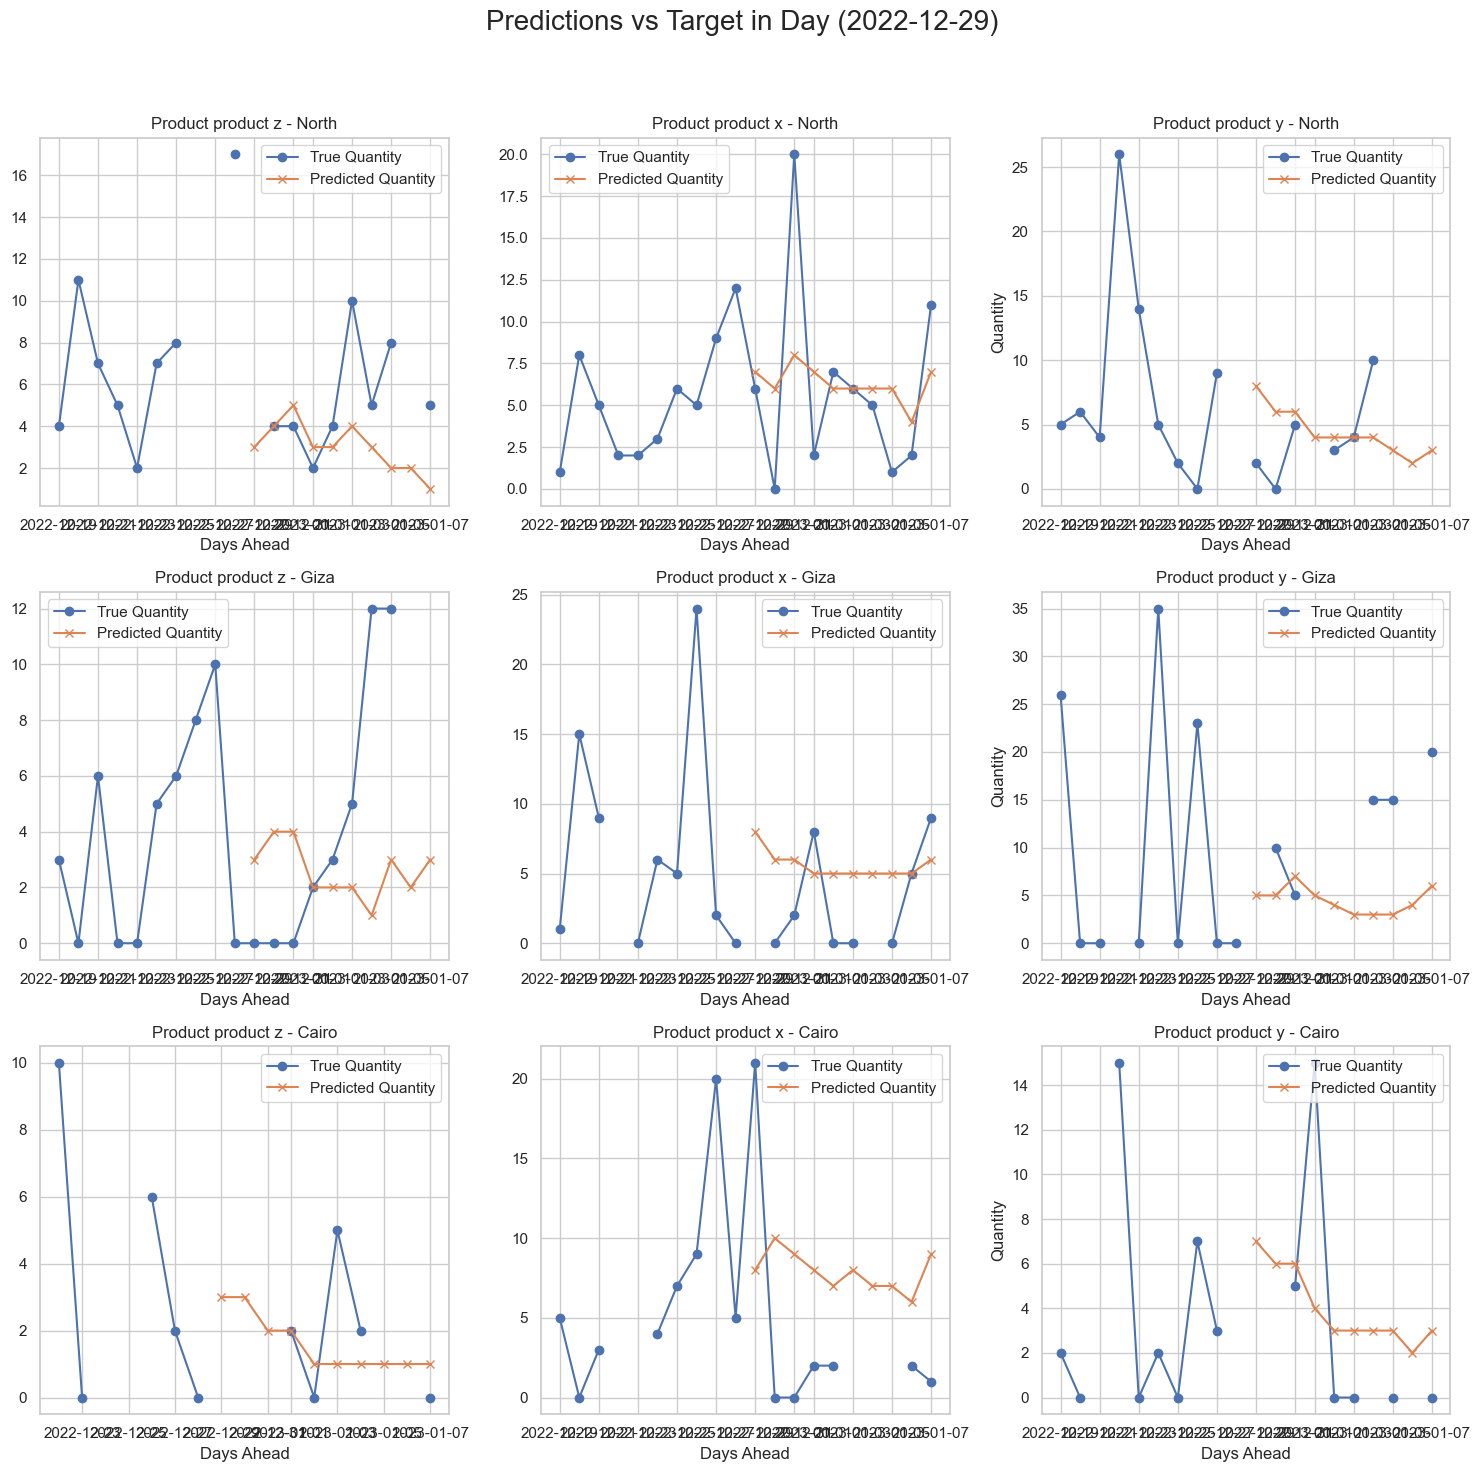

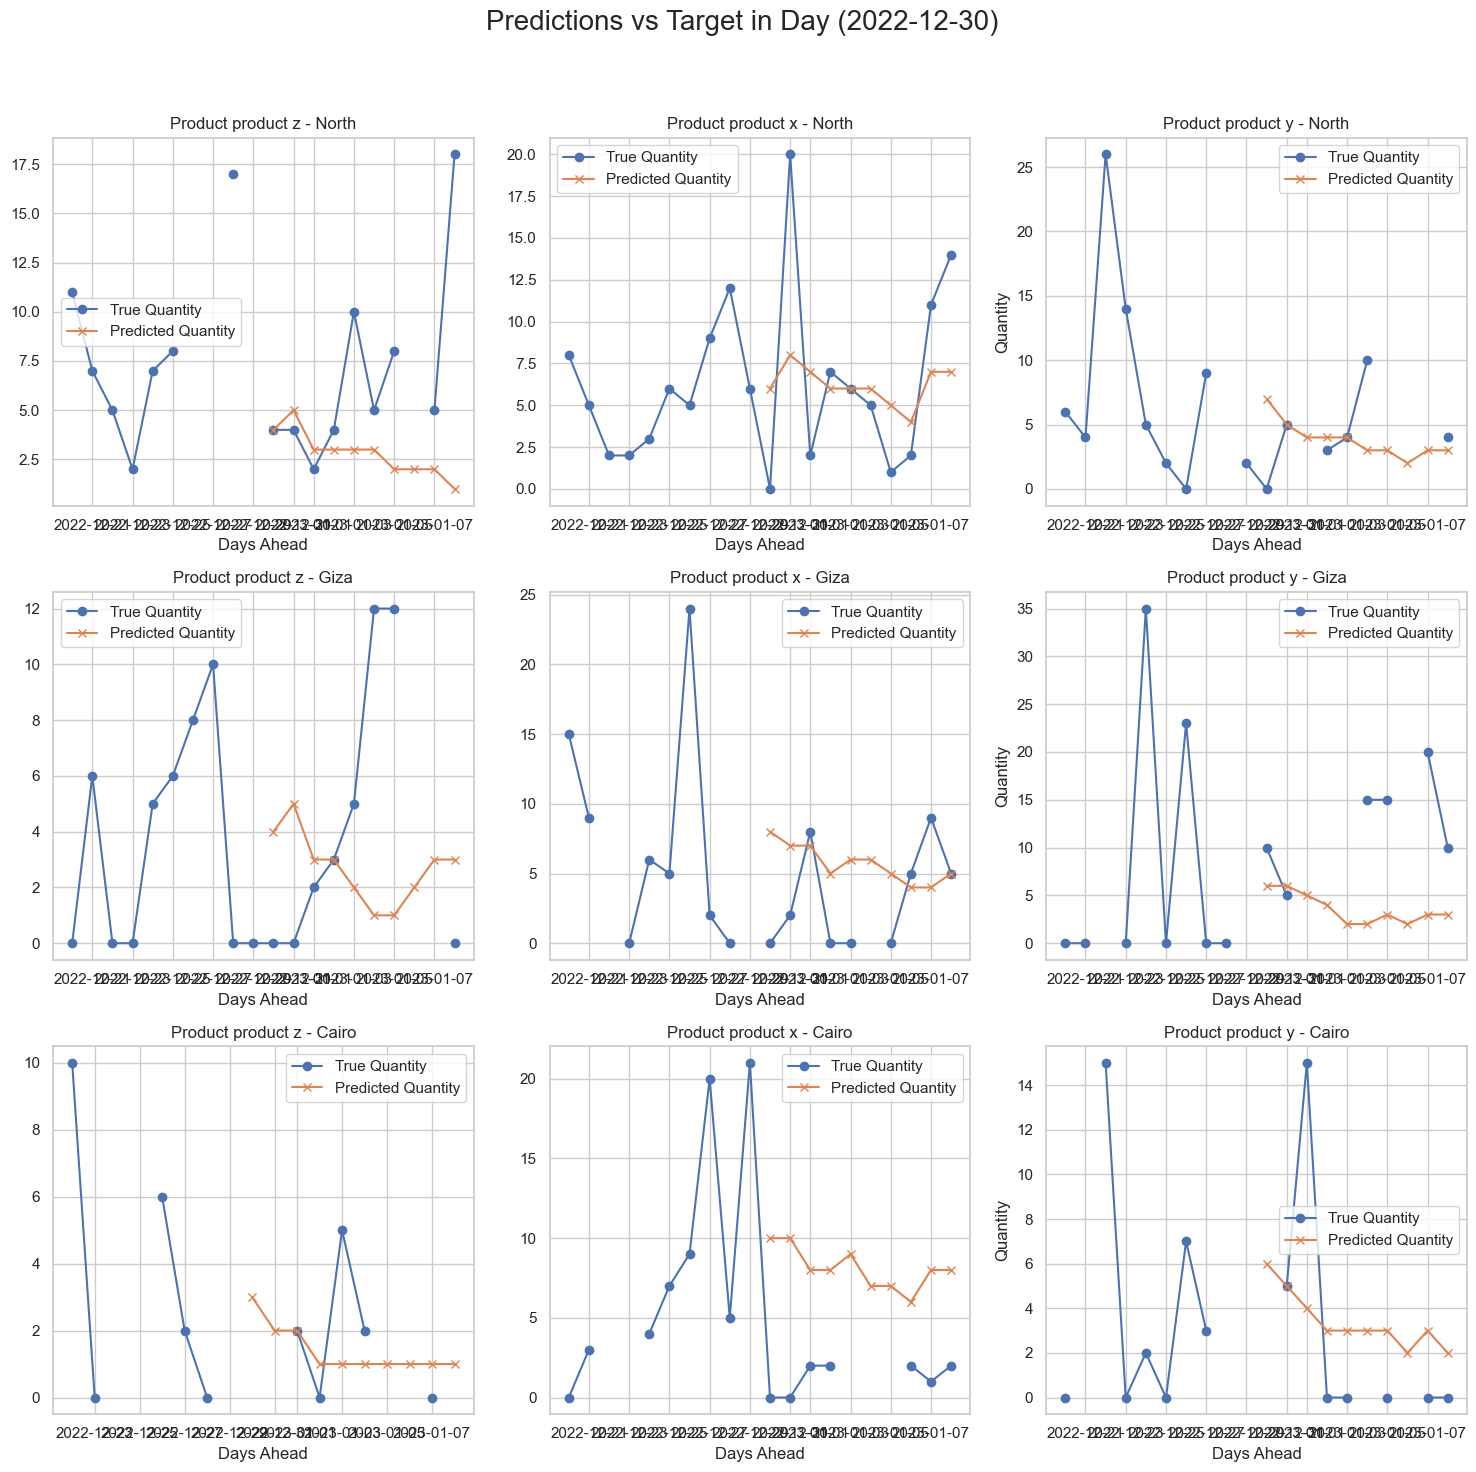

In [180]:
days = df_ml.time_step.unique()[-20:-20+2]

max_lag = max(max(lags_quantity), max(lags_price))
horizon = 10
cities = df_ml.city.unique()
products = df_ml.product_name.unique()

# rand_day = np.random.randint(100,len(df_ml.time_step.unique()) - 20)
# days = df_ml.time_step.unique()[rand_day:rand_day+5]

for day in days:
    day = str(day.date())
    plt.figure(figsize=(15, 15))
    plt.suptitle(f"Predictions vs Target in Day ({day})", fontsize=20)
    
    j = 0
    for city in cities:
        for product in products:
            pred = autoregressive_prediction(
                df_ml, city, product, lags_quantity, lags_discount, lags_price, rolling_by,
                start_pred_date=day, horizon=horizon, max_lag=max_lag,take_last=10
            )
            
            targets = pred['target_quantity']
            predictions = pred['predicted_quantity']
            
            plt.subplot(3, 3, j + 1)
            
            # Plot lines
            plt.plot(targets, label="True Quantity", marker='o')
            plt.plot(predictions, label="Predicted Quantity", marker='x')
        
            
            plt.title(f'Product {product} - {city}')
            plt.xlabel('Days Ahead')
            
            if (j + 1) % 3 == 0:
                plt.ylabel('Quantity')
                
            j += 1
            plt.legend(loc='best')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### 8.2 Evaluate the Last 10 Days (No Target Data)

1. **Set prediction parameters** including `max_lag`, `horizon`, and the start date for predictions.
2. **Select the last day in the dataset** and calculate the next day as the start date for predictions.
3. **Generate predictions** for all city-product combinations using the `autoregressive_prediction` function.
4. **Plot the predicted vs actual quantities** for each city-product pair in a 3x3 subplot grid.
5. **Display the plots** for easy comparison, adjusting layout to fit all subplots and adding labels for clarity.

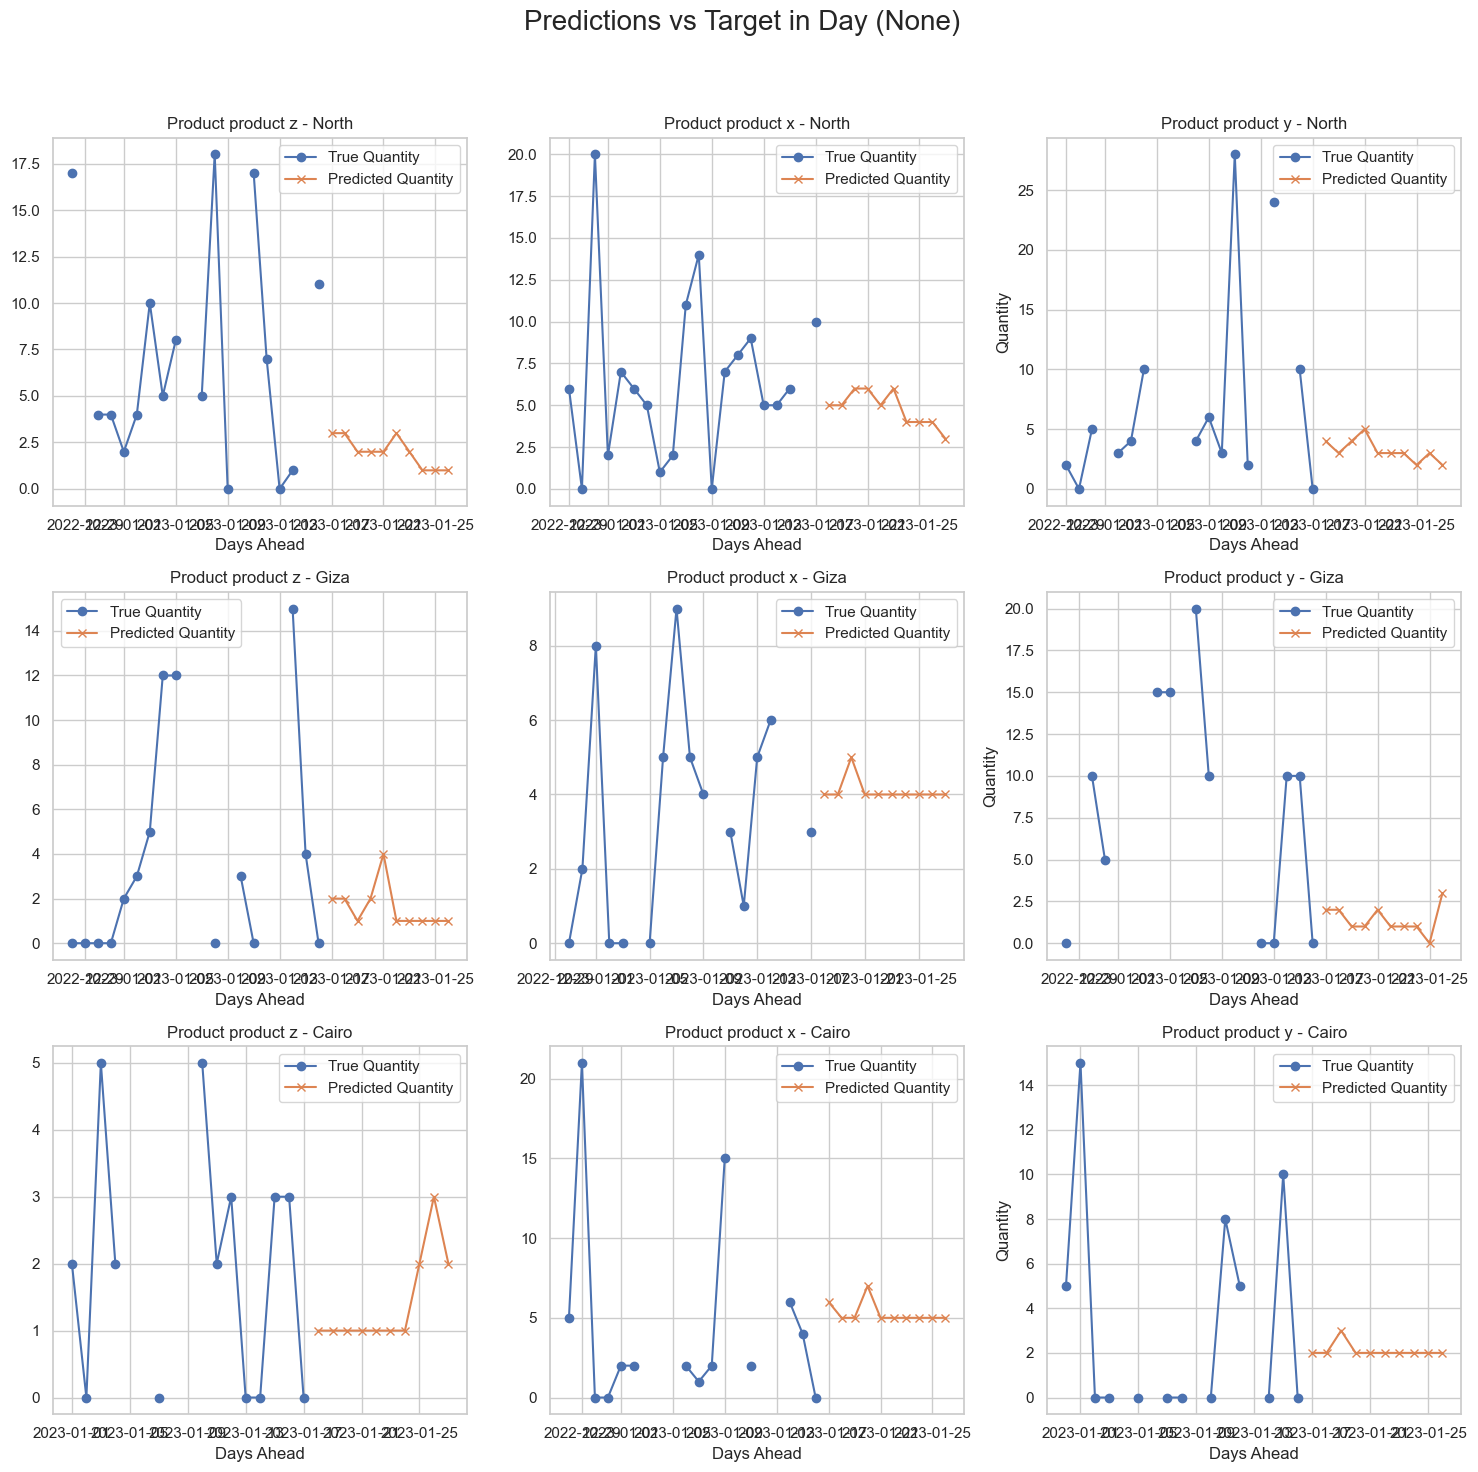

In [181]:
### last 10 days I don't have target for.
max_lag = max(max(lags_quantity), max(lags_price), max(lags_discount))
# start_pred_day = '2022-12-29'
start_pred_day = str((df_ml.iloc[-1].time_step + pd.Timedelta(days=1) ).date())
start_pred_day = None
horizon = 10
cities = df_ml.city.unique()
products = df_ml.product_name.unique()


plt.figure(figsize=(15, 15))  # Create a new figure for each day
plt.suptitle(f"Predictions vs Target in Day ({start_pred_day})", fontsize=20)  # Add a main title for the figure

j = 0  # Counter for indexing targets and prediction
for city in cities:
    for product in products:
        pred = autoregressive_prediction(df_ml, city, product, lags_quantity, lags_discount,lags_price, rolling_by, start_pred_date=start_pred_day, horizon=horizon,max_lag=max_lag, take_last=20)

        # targets = pred['target_quantity']
        # predictions = pred['predicted_quantity']
        plt.subplot(3, 3, j + 1)  # Arrange subplots in a 3x3 grid

        plt.plot(pred['target_quantity'], label="True Quantity", marker='o')
        plt.plot(pred['predicted_quantity'], label="Predicted Quantity", marker='x')

        plt.title(f'Product {product} - {city}')
        plt.xlabel('Days Ahead')

        # Set ylabel only for the first subplot in the rightmost column
        if (j + 1) % 3 == 0:  # Subplots in the rightmost column have indices 3, 6, 9
            plt.ylabel('Quantity')
        j += 1  # Increment subplot index
        plt.legend(loc='best')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to leave space for the main title
plt.show()  # Show the figure for the current day

### 8.3 Numerical Evaluation

1. **Define the evaluation period** by setting the start and end days based on `max_lag` and `horizon`.
2. **Generate predictions** for all city-product combinations over the specified days using the `autoregressive_prediction` function.
3. **Store the actual and predicted quantities** for each day, city, and product.
4. **Mask missing data** and ensure that the targets and predictions are appropriately handled for evaluation.
5. **Calculate evaluation metrics** (MAE, RMSE, SMAPE) for each city-product pair using a custom function `calculate_metrics`.
6. **Prepare a metrics dataframe** containing MAE, RMSE, and SMAPE for each city-product combination.

In [182]:
max_lag = max(max(lags_quantity), max(lags_price), max(lags_discount))
horizon = 10
cities = df_ml.city.unique()
products = df_ml.product_name.unique()

start_day = df_ml.time_step.min() + pd.Timedelta(days=max_lag)
end_day = df_ml.time_step.max() - pd.Timedelta(days=horizon+1)


start_day = start_day +  pd.Timedelta(days=300)
days = pd.date_range(start=start_day,end=end_day,freq='D')

all_targets = np.zeros((len(days), horizon , 9))
all_pred = np.zeros((len(days), horizon , 9))

In [183]:
for day in days:
    day = str(day.date())
    i = 0
    for city in cities:
        for product in products:
            pred = autoregressive_prediction(
                df_ml, city, product, lags_quantity,lags_discount, lags_price,rolling_by,
                start_pred_date=day, horizon=horizon, max_lag=max_lag, take_last=0,
            )

            all_targets[0,:,i] = pred['target_quantity']
            all_pred[0,:,i] = pred['predicted_quantity']
            i += 1
masked_arr = np.where(np.isnan(all_targets), 0, 1)
all_targets =  np.nan_to_num(all_targets, nan=0)
masked_pre = all_pred * masked_arr
def calculate_metrics(predictions, targets, cities, products):
    """
    Calculate MAE, RMSE, and SMAPE for each city/product pair.
    """
    # Number of products, and cities
    num_features = targets.shape[2]
    
    # Initialize metrics arrays
    mae = np.zeros((num_features,))
    rmse = np.zeros((num_features,))
    smape = np.zeros((num_features,))

    # Calculate metrics for each city/product (features)
    for i in range(num_features):
        mae[i] = mean_absolute_error(targets[:, :, i], predictions[:, :, i])
        rmse[i] = np.sqrt(mean_squared_error(targets[:, :, i], predictions[:, :, i]))
        
        # Calculate SMAPE
        denominator = np.abs(predictions[:, :, i]) + np.abs(targets[:, :, i])
        # Avoid division by zero or NaN values
        denominator = np.where(denominator == 0, 1, denominator)
        smape[i] = np.mean(2 * np.abs(predictions[:, :, i] - targets[:, :, i]) / denominator) * 100

    # Prepare the metrics dataframe
    metrics_df = {
        'MAE': mae,
        'RMSE': rmse,
        'SMAPE': smape
    }

    metrics_df = pd.DataFrame(metrics_df, index=[f'Product {p} - [{city}]' for city in cities for p in products])

    return metrics_df

metrics = calculate_metrics(all_pred, all_targets, cities, products)

In [188]:
metrics['SMAPE'].mean()

3.536441577192491

# 6. Next Steps and Future Improvements

As part of the future work and advancements for improving the model's performance and robustness, I plan to focus on the following areas:

1. **Feature Extraction**: I will explore techniques to extract more relevant and insightful features from the given data. This can help in enhancing the model’s ability to understand complex patterns and make more accurate predictions.

2. **Transformer Models**: I plan to investigate the use of transformer models, particularly their attention mechanisms. By leveraging the parallelization benefits of hardware accelerators like GPUs, transformers could significantly improve performance, especially in handling long-range dependencies in time series data.

3. **Reading Relevant Research Papers**: I have identified some interesting papers that I will review to gain deeper insights into time series forecasting and data augmentation techniques. These papers are:
    - **Time Series Data Cleaning with Regular and Irregular Time Intervals**  
      [Link to Paper](https://arxiv.org/abs/2004.08284)
    - **Data Augmentation Techniques in Time Series Domain: A Survey and Taxonomy**  
      [Link to Paper](https://arxiv.org/abs/2206.13508)
    - **Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting**  
      [Link to Paper](https://arxiv.org/abs/1912.09363)

These papers will provide a deeper understanding of various techniques for improving time series forecasting, data cleaning, and augmentation.